In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(Seurat)
    library(EnsDb.Hsapiens.v86)
    library(dplyr)
    library(ggplot2)
    library(bedr)
    library(SeuratDisk)
    library(scales)
    library(reshape2)
    library(Hmisc)
    library(tidyr)
    library(tidyverse)
    library(crayon)
    library(readr)
    library(future)
    library("TxDb.Hsapiens.UCSC.hg38.knownGene")
    library(GenomicRanges)
    library(GenomicFeatures)
    library(rsnps)
    library(biomaRt)
    library(ggpubr)
    library(gridExtra)
    library(patchwork)
    library(EnhancedVolcano)
    library(rlist)
    library(purrr)
}))
options(timeout=100000)
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')

# Definitions etc

In [2]:
set.seed(1234)
options(digits=2)
stats <- c()

In [3]:
options(future.globals.maxSize= 250 * 1024^3) # 650Gb
# plan()

# Enable parallelization
plan(sequential)
plan("multicore", workers = 64)

In [4]:
if(!exists("papermill_run")) {
    prj_name = "Screen1_66guides"
    data_subdir_suffixes = "L1,L2,L3,L4"     
    secondary_a_path = "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/"
    save_seurat_h5 = "YES"
}

In [5]:
custom_theme <- theme(
  plot.title = element_text(size=16, hjust = 0.5), 
  legend.key.size = unit(0.7, "cm"), 
  legend.text = element_text(size = 14))

Mark cells that are positive for given guides as target_positive, all others as target_negative

In [6]:
# mark_guide_pos_neg <- function(seurat_obj, perturbed_cells_by_guide, guides, print_counts = T) {
#     all_cells = Cells(seurat_obj)
#     perturbed_cells = c()
#     dummy_perturbed = c()
    
#     for(guide in guides) {
#         dummy_perturbed = unlist(perturbed_cells_by_guide[[guide]])
#         perturbed_cells = union(perturbed_cells, dummy_perturbed)
#         #cat(guide," ", length(perturbed_cells), "\n")
#     }

#     unperturbed_cells = unlist(setdiff(all_cells, perturbed_cells))
#     Idents(seurat_obj) <- "target_negative"
#     seurat_obj <- SetIdent(seurat_obj, cells = perturbed_cells, value = "target_positive") 

#     if(print_counts) {
#         n_gplus   = length(perturbed_cells)
#         n_gminus = length(unperturbed_cells)    
#         cat(blue("Guide+ =",n_gplus, "; Guide- =", n_gminus, "\n"))
#     }
    
#     seurat_obj
# }

### Load guide df

In [7]:
#df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/101_CRISPRa_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
df_guide = read.table("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/66CRISPRi_ref_for_diffex.txt", sep = "\t", header = T, strip.white = T)
sample_n(df_guide, 6)

gene,guide1,guide2,alias,subclass,class,gene_or_rsid,label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
rs7707989,DE4-2a,DE4-2b,DE4,ckd_de,targeting,rs7707989,CKD DE
rs2823139,DE1-2a,DE1-2b,DE1,ckd_de,targeting,rs2823139,CKD DE
rs881858,DE9-1a,DE9-1b,DE9,ckd_de,targeting,rs881858,CKD DE
rs6839100,DE12-2a,DE12-2b,DE12,ckd_de,targeting,rs6839100,CKD DE
rs4720089,DE14-1a,DE14-1b,DE14,ckd_de,targeting,rs4720089,CKD DE
Enh37-10-PLIN3,PLIN3-1a,PLIN3-1b,PLIN3,de_control,targeting,PLIN3,Control DE


### Load Seurat file

In [8]:
integrated_h5_path <- "/home/vsevim/prj/1012-ckd/S1/analysis/secondary/integrated/seurat_objects/integrated.h5seurat"
seurat_combined    <- LoadH5Seurat(integrated_h5_path, verbose = F)
#seurat_combined    <- subset(seurat_combined, subset=status=='singlet')

Validating h5Seurat file

Warning message:
"Adding a command log without an assay associated with it"


Normalize RNA counts by <font color='red'>NormalizeData</font>  before running FindMarkers

In [9]:
seurat_rna = CreateSeuratObject(seurat_combined[['RNA']])
seurat_rna <- NormalizeData(seurat_rna)
seurat_rna@meta.data <- seurat_combined@meta.data

### Load THRESHOLDS.tsv

In [10]:
thr_f_name = paste0(secondary_a_path, "/integrated/THRESHOLDS.tsv")
df_thresholds = read.table(thr_f_name, header=T, strip.white = T)
df_thresholds <- df_thresholds %>% pivot_wider(names_from = batch, values_from = threshold)
df_thresholds <- as.data.frame(df_thresholds)

## Select perturbed/control cells
Find guide+ (perturbed) and guide- (unperturbed) cells for each guide

In [11]:
libraries = unique(seurat_combined$library)
seurat_libs = list()
for(i in seq_along(libraries)){ 
    lib = libraries[i]
    seurat_libs[[i]] = subset(seurat_combined, subset = library == lib)
}
names(seurat_libs) <- libraries

In [12]:
cat(red("Using 3x threshold"))
THRESHOLD_MULTIPLIER = 1

perturbed_cells_by_guide = list()

for(i in 1:nrow(df_thresholds)){  
    perturbed_cells_in_all_libs = list()
    guide = df_thresholds$guide[i]
    # Loop over libraries
    for(lib in libraries){        
        seurat_lib = seurat_libs[[lib]]
        threshold = THRESHOLD_MULTIPLIER * df_thresholds[i, lib]        
        #cat(blue(guide, lib, threshold, "\n"))
        cells_in_lib = Cells(seurat_lib)        
        sgrna_counts = seurat_lib[['sgRNA']]@counts
        select_perturbed = sgrna_counts[guide, cells_in_lib] >= threshold
        perturbed_cells_in_library = cells_in_lib[select_perturbed]
        #cat(length(cells_in_lib), "in", lib, guide, length(perturbed_cells_in_library), "cells >", threshold, "\n")        
        if(!is.na(threshold)) {
            perturbed_cells_in_all_libs = append(perturbed_cells_in_all_libs, perturbed_cells_in_library)
        }
    }
    perturbed_cells_by_guide[[i]] = perturbed_cells_in_all_libs
}
names(perturbed_cells_by_guide) <- df_thresholds$guide

Using 3x threshold

In [13]:
length(perturbed_cells_by_guide[[3]])

[1] 796

In [14]:
df_thresholds$guide[grepl("NT" , df_thresholds$guide)]

[1] "NTCE1-1a" "NTCE1-1b" "NTCE2-1a" "NTCE2-1b" "NTCE3-1a" "NTCE3-1b" "NTCE4-1a"
[8] "NTCE4-1b"

# Check DE for genes near SNPs

In [16]:
select_distal  = df_guide$subclass == 'ckd_de'
df_snps = unique(df_guide[select_distal, c('gene','alias')])

* * * * *
I skip DE 20 because it doesn't have a rsID. Use it's coords instead 
* * * * *

In [17]:
snp_coords = ncbi_snp_query(df_snps$gene)

Getting info about the following rsIDs: rs2823139, rs7642977, rs78581838, rs7707989, rs527616, rs10283362, rs34861762, rs16874072, rs881858, rs4669722, rs76839935, rs6839100, rs11154336, rs4720089, rs2979488, rs2661503, rs10224210



In [18]:
#snp_upstream_range   = 1000000
#snp_downstream_range = 1000000

df_snp_coords                 = data.frame(chr=paste0("chr", snp_coords$chromosome))
df_snp_coords$start_position  = snp_coords$bp #+ snp_upstream_range
df_snp_coords$end_position    = snp_coords$bp #+ snp_downstream_range
df_snp_coords$strand          = '*'
df_snp_coords$hgnc_symbol     = snp_coords$rsid
df_snp_coords$chromosome_name = snp_coords$chromosome
#snp_granges = makeGRangesFromDataFrame(df_dummy)

Include distal elements with no rs number

In [19]:
select_distal  = df_guide$subclass == 'ckd_de_no_rs'
if(any(select_distal)) {
    df_nors_snps = unique(df_guide[select_distal, c('gene','alias')])
    chr_and_coords = str_split(df_nors_snps$gene, "_")
    df_dummy = data.frame(t(Reduce(rbind, chr_and_coords)))
    colnames(df_dummy) <- c("chr", "start")

    df_nors_snps$chr = paste0('chr', df_dummy$chr)
    df_nors_snps$start_position  = as.numeric(df_dummy$start)
    df_nors_snps$end_position    = as.numeric(df_dummy$start)
    df_nors_snps$strand          = "*"
    df_nors_snps$hgnc_symbol     = df_nors_snps$gene
    df_nors_snps$chromosome_name = df_dummy$chr

    select_cols = c('chr', 'start_position', 'end_position','strand', 'hgnc_symbol', 'chromosome_name')
    df_nors_snps = df_nors_snps[, select_cols]
    df_snp_coords = rbind(df_snp_coords, df_nors_snps)
}

In [20]:
head(df_snp_coords)

,chr,start_position,end_position,strand,hgnc_symbol,chromosome_name
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,chr21,1.5e+07,1.5e+07,*,rs2823139,21
2,chr3,1.9e+08,1.9e+08,*,rs7642977,3
3,chr21,1.5e+07,1.5e+07,*,rs78581838,21
4,chr5,6.8e+07,6.8e+07,*,rs7707989,5
5,chr18,2.7e+07,2.7e+07,*,rs527616,18
6,chr8,1.3e+08,1.3e+08,*,rs10283362,8


Load annotations

In [21]:
#searchDatasets(mart = ensembl, pattern = "hsapiens")
#mart <- useMart("ensembl")
#mart <- useDataset("hsapiens_gene_ensembl", mart)

# Find neighbors of targets

In [22]:
genes_in_assay = rownames(seurat_rna[['RNA']]@counts)
options(timeout=100000)
mart <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl", mirror="useast")
#m <- useMart('ensembl', dataset='hsapiens_gene_ensembl') # create a mart object

Ensembl site unresponsive, trying www mirror



In [23]:
source('/home/vsevim/prj/workflows/ckd/secondary/helper_functions_for_diffex.r')
control_targets = unique(filter(df_guide, subclass=='tss' | subclass == 'de_control')[,c('alias')])

df_target_coords <- getBM(mart=mart, attributes=c('hgnc_symbol', 'description', 'chromosome_name',
                                 'start_position', 'end_position', 'strand',
                                 'ensembl_gene_id'),
                        filters = 'hgnc_symbol', values = control_targets)
                        
df_target_coords <- filter(df_target_coords, chromosome_name %in% c(1:23, "X","Y"))

In [24]:
gene_neighbors_list = get_neighboring_genes(bm, df_target_coords, genes_in_assay)
snp_neighbors_list  = get_neighboring_genes(bm, df_snp_coords, genes_in_assay)
neighbors_list =  append(gene_neighbors_list, snp_neighbors_list) 

ANPEP 15 88784895 90815401 
C15orf40 15 81988441 84011641 
CD55 1 206321519 208386804 
CSTB 21 42772511 44776330 
CTSB 8 10842524 12869533 
FTH1 11 60959718 62967634 
FUBP1 1 76944055 78979110 
KLF6 10 2775996 4785281 
LGALS3 14 54124110 56145423 
MAFF 22 37200767 39216507 
NT5E 6 84449584 86495791 
PLIN3 19 3838341 5867694 
TKT 3 52224712 54256052 
rs2823139 21 14204463 16204463 
rs7642977 3 193092961 195092961 
rs78581838 21 13864259 15864259 
rs7707989 5 67396052 69396052 
rs527616 18 25757460 27757460 
rs10283362 8 132320717 134320717 
rs34861762 8 22890907 24890907 
rs16874072 4 22741827 24741827 
rs881858 6 42838872 44838872 
rs4669722 2 10390110 12390110 
rs76839935 7 150870466 152870466 
rs6839100 4 75458036 77458036 
rs11154336 6 124899862 126899862 
rs4720089 7 31964026 33964026 
rs2979488 8 29423114 31423114 
rs2661503 6 50644819 52644819 
rs10224210 7 150716108 152716108 


# Load neighbors list

In [15]:
neighbors_list = list.load("/home/vsevim/prj/1012-ckd/S1/scripts/library_csv/neighbors_list.rds")

### Q

# Run diffex on pseudobulked samples using DESeq2

In [26]:
df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene','subclass', 'label')])
df_targets = unique(filter(df_guide, class=='targeting')[,c('alias','gene','subclass', 'label')])
df_neighbor_de = NULL
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.01


for(i in 1:nrow(df_targets)) {
    i = 28
    target          = df_targets[i,'alias']
    target_subclass = df_targets[i, 'subclass']
    label           = df_targets[i, 'label']
    snp_id_or_gene_name = df_targets[i,'gene']
    
    if(!str_detect(target, regex("^DE\\d+$"))) {
        ckd_de = 
        neighbors = neighbors_list[[target]]
    } else {
        neighbors = neighbors_list[[snp_id_or_gene_name]]
    }

    if((target %in% guides_to_skip) | length(neighbors) == 0 ){
        cat(red("Skipping", target, snp_id_or_gene_name, length(neighbors), "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    cat(blue(target, target,":"), paste(guides_4_target, collapse=","),"\n")
    seurat_dummy <- mark_guide_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
    seurat_dummy$psbulk_replicate_id = Idents(seurat_dummy)
    seurat_dummy$psbulk_replicate_id = paste0(seurat_dummy$psbulk_replicate_id, "_", seurat_dummy$donor)
    Idents(seurat_dummy) = seurat_dummy$psbulk_replicate_id

    counts <- AggregateExpression(
        seurat_dummy,            
        assays = 'RNA',
        slot = "counts",
        return.seurat = FALSE
    )
    #
    break
}


DE15 DE15 : DE15-1a,DE15-2a,DE15-1b,DE15-2b 
Guide+ = 2198 ; Guide- = 24944 


In [27]:
df_counts <- as.data.frame(counts$RNA)
df_counts <- df_counts[, sort(colnames(df_counts))]
head(df_counts, 20)

,guide_negative_0,guide_negative_1,guide_negative_2,guide_negative_3,guide_positive_0,guide_positive_1,guide_positive_2,guide_positive_3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MIR1302-2HG,1,0,0,2,0,0,0,1
FAM138A,0,0,0,0,0,0,0,0
OR4F5,1,1,0,4,0,0,0,0
AL627309.1,60,65,76,64,7,6,8,8
AL627309.3,4,3,3,1,0,1,3,0
AL627309.2,0,0,0,0,0,0,0,0
AL627309.5,63,100,119,74,7,8,12,7
AL627309.4,1,2,1,0,0,1,1,0
AP006222.2,0,0,1,1,0,0,0,0


In [28]:
col_data = data.frame(c(rep(c("Control"),4), rep(c("Stimulated"),4)))
rownames(col_data) = colnames(df_counts)
colnames(col_data) = "condition"
col_data

,condition
,<chr>
guide_negative_0,Control
guide_negative_1,Control
guide_negative_2,Control
guide_negative_3,Control
guide_positive_0,Stimulated
guide_positive_1,Stimulated
guide_positive_2,Stimulated
guide_positive_3,Stimulated


In [29]:
# Create DESeq2 object   
library(DESeq2)
dds <- DESeqDataSetFromMatrix(
    countData = df_counts,
    colData = col_data,
    design = ~ condition
)

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: 'matrixStats'


The following object is masked from 'package:dplyr':

    count


The following objects are masked from 'package:Biobase':

    anyMissing, rowMedians



Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCum

In [30]:
keep <- rowSums(counts(dds)) >=5
dds <- dds[keep,]

In [31]:
# run DESeq2
dds <- DESeq(dds, )

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



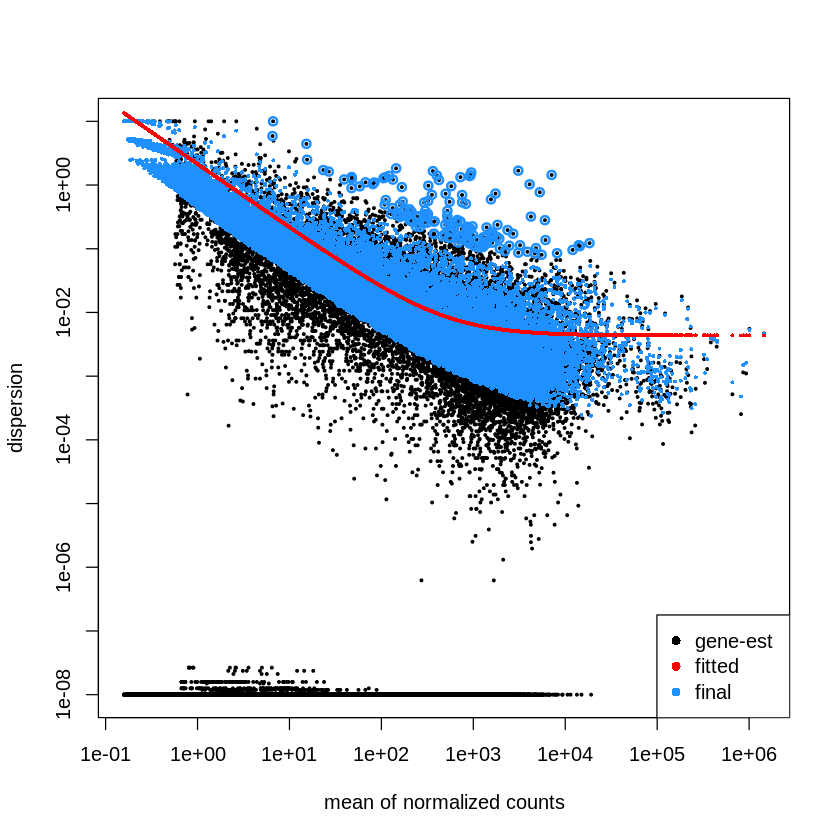

In [32]:
plotDispEsts(dds)

In [33]:
resultsNames(dds)

[1] "Intercept"                       "condition_Stimulated_vs_Control"

In [34]:
# Generate results object
#res <- results(dds, name = "condition_Stimulated_vs_Control")
res <- results(dds, contrast=c("condition","Control", "Stimulated"))
res

# Run diffex on pseudobulked samples using EdgeR

In [16]:
library(edgeR)

Loading required package: limma




Attaching package: 'limma'


The following object is masked from 'package:BiocGenerics':

    plotMA




In [239]:
df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene','subclass', 'label')])
df_targets = unique(filter(df_guide, class=='targeting')[,c('alias','gene','subclass', 'label')])
df_neighbor_de = NULL
df_cell_counts = NULL
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.01


for(i in 1:nrow(df_targets)) {
    is_de = FALSE
    target          = df_targets[i,'alias']
    target_subclass = df_targets[i, 'subclass']
    label           = df_targets[i, 'label']
    snp_id_or_gene_name = df_targets[i,'gene']
    
    if(!str_detect(target, regex("^DE\\d+$"))) {
        ckd_de = 
        neighbors = neighbors_list[[target]]
    } else {
        is_de = TRUE
        neighbors = neighbors_list[[snp_id_or_gene_name]]
    }

    if((target %in% guides_to_skip) | length(neighbors) == 0 ){
        cat(red("Skipping", target, snp_id_or_gene_name, length(neighbors), "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    cat(blue(target, target,":"), paste(guides_4_target, collapse=","),"\n")
    seurat_dummy <- mark_target_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
    seurat_dummy$perturbation_status = Idents(seurat_dummy)
    #seurat_dummy$psbulk_replicate_id = paste0(seurat_dummy$donor, "_", seurat_dummy$perturbation_status)
    #Idents(seurat_dummy) = seurat_dummy$psbulk_replicate_id
    seurat_dummy$donor = paste0("donor", seurat_dummy$donor)
    print(table(filter(seurat_dummy@meta.data, perturbation_status == 'target_positive')$donor) )


    # Use each donor as a replicate
    cluster_list = as.character(seurat_dummy$perturbation_status)
    cluster_list[cluster_list == "target_negative"] = 1
    cluster_list[cluster_list == "target_positive"] = 0
    seurat_dummy$cluster = as.factor(cluster_list)
    y = Seurat2PB(seurat_dummy, sample = "donor", cluster = 'cluster')

    # Add target+/- counts to df_cell_counts
    if(!is_de) {
        df_dummy = as.data.frame(y$counts[target,])
        colnames(df_dummy) = "count"
        df_dummy$target <- target
        df_dummy$label = rownames(df_dummy)
        df_samples = y$samples
        df_dummy = merge(df_dummy, df_samples, by = 0)
        df_cell_counts = rbind(df_cell_counts, df_dummy)
    }

    # Filter out small samples, lowly expressed genes.
    keep.samples <- y$samples$lib.size > 5e4
    table(keep.samples)
    y <- y[, keep.samples]
    keep.genes <- filterByExpr(y, group=y$samples$cluster, min.count=10, min.total.count=20)
    table(keep.genes)
    y <- normLibSizes(y)

    # Create design matrix
    donor <- factor(y$samples$sample)
    cluster <- as.factor(y$samples$cluster)
    design <- model.matrix(~ cluster + donor)
    colnames(design) <- gsub("donor", "", colnames(design))
    colnames(design)[1] <- "Int"

    ncls <- nlevels(cluster)
    contr <- rbind( matrix(1/(1-ncls), ncls, ncls), matrix(0, ncol(design)-ncls, ncls) )
    diag(contr) <- 1
    contr[1,] <- 0
    rownames(contr) <- colnames(design)
    colnames(contr) <- paste0("cluster", levels(cluster))
    
    # Estimate dispersion
    y <- estimateDisp(y, design, robust=TRUE)
    y$common.dispersion

    # Fit
    fit <- glmQLFit(y, design, robust=TRUE)
    qlf <- glmQLFTest(fit, contrast=contr[,1])
    markers <- qlf$table[neighbors, ] %>% arrange(PValue)

    markers$de_gene = rownames(markers)
    markers$target = target
    markers$subclass = target_subclass
    markers$label = label
    rownames(markers) <- NULL
    df_neighbor_de = rbind(df_neighbor_de, markers)
    print(head(markers))
    cat("-------------------------------------------------------\n\n")
}


ANPEP ANPEP : CD13-1a,CD13-1b 
CD13-1a   867 
CD13-1b   1161 
Guide+ = 1161 ; Guide- = 25981 

donor0 donor1 donor2 donor3 
   270    233    385    273 
  logFC logCPM    F   PValue de_gene target subclass       label
1 -1.32    6.9 1122 2.6e-207   ANPEP  ANPEP      tss Control TSS
2 -0.33    6.7   76  2.5e-18    IDH2  ANPEP      tss Control TSS
3 -0.20    6.7   27  1.8e-07  SEMA4B  ANPEP      tss Control TSS
4  0.23    5.4   23  1.5e-06   AP3S2  ANPEP      tss Control TSS
5  0.21    5.4   19  1.5e-05   MFGE8  ANPEP      tss Control TSS
6 -0.36    3.5   15  1.2e-04   FANCI  ANPEP      tss Control TSS
-------------------------------------------------------

CD55 CD55 : CD55-1a,CD55-1b 
CD55-1a   796 
CD55-1b   1081 
Guide+ = 1081 ; Guide- = 26061 

donor0 donor1 donor2 donor3 
   253    220    319    289 
  logFC logCPM     F  PValue  de_gene target subclass       label
1 -2.20    4.1 432.1 8.8e-96     CD55   CD55      tss Control TSS
2 -0.32    2.6   6.2 1.3e-02 C1orf116   CD55      ts

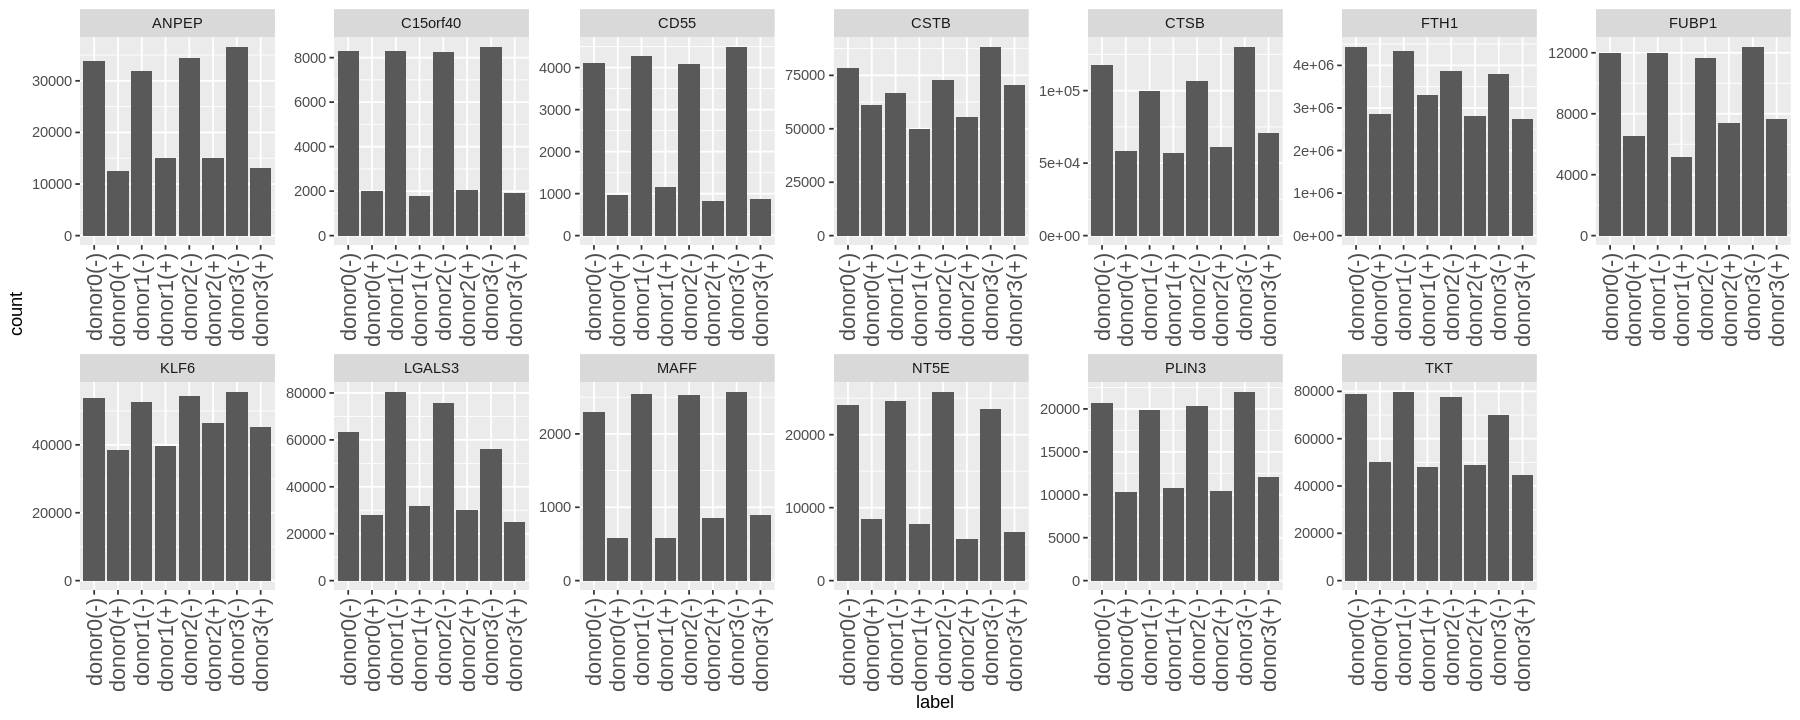

In [251]:
df_cell_counts$label = str_replace(df_cell_counts$label, "_cluster0", "(+)")
df_cell_counts$label = str_replace(df_cell_counts$label, "_cluster1", "(-)")

df_cell_counts$norm_count = max(df_cell_counts$lib.size) * df_cell_counts$count/df_cell_counts$lib.size

options(repr.plot.width=15, repr.plot.height=6)
ggplot(df_cell_counts, aes(label)) +
    geom_bar(aes(weight=norm_count)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 13)) +
    facet_wrap(~ target, scales="free", ncol = 7)

## Inpect DE results

Print top high-confidence hits

In [163]:
df_neighbor_de %>% filter(logFC < 0) %>% arrange(PValue) %>% head(25)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,-1.29,7.9,2409,0.0e+00,LGALS3,LGALS3,de_control,Control DE
2,-0.90,8.7,1612,8.8e-302,CTSB,CTSB,de_control,Control DE
3,-1.32,6.9,1122,2.6e-207,ANPEP,ANPEP,tss,Control TSS
4,-0.95,6.3,802,9.8e-176,PLIN3,PLIN3,de_control,Control DE
5,-2.14,4.9,790,3.1e-173,C15orf40,C15orf40,tss,Control TSS
6,-1.00,6.0,908,9.3e-171,NDRG1,DE6,ckd_de,CKD DE
7,-1.85,6.4,1291,6.0e-165,NT5E,NT5E,tss,Control TSS
8,-0.70,8.2,632,3.9e-139,TKT,TKT,de_control,Control DE
9,-0.47,8.3,521,5.2e-115,RBPMS,DE15,ckd_de,CKD DE


In [164]:
df_neighbor_de %>% filter((subclass == 'tss')) %>% filter(logFC < 0) %>% arrange(PValue) %>% head(20)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,-1.32,6.91,1122.3,2.6e-207,ANPEP,ANPEP,tss,Control TSS
2,-2.14,4.94,790.1,3.1e-173,C15orf40,C15orf40,tss,Control TSS
3,-1.85,6.37,1290.8,6.0e-165,NT5E,NT5E,tss,Control TSS
4,-2.20,4.06,432.1,8.8e-96,CD55,CD55,tss,Control TSS
5,-0.86,5.59,246.5,5.1e-55,FUBP1,FUBP1,tss,Control TSS
6,-1.82,3.37,167.0,3.5e-38,MAFF,MAFF,tss,Control TSS
7,-0.33,6.66,76.3,2.5e-18,IDH2,ANPEP,tss,Control TSS
8,-0.19,10.47,57.9,2.7e-14,LGALS1,MAFF,tss,Control TSS
9,-0.20,6.72,27.3,1.8e-07,SEMA4B,ANPEP,tss,Control TSS


In [165]:
df_neighbor_de %>% filter((subclass == 'ckd_de')) %>% filter(PValue < 1e-5) %>% arrange(PValue) %>% head(30)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,-1.00,6.00,908,9.3e-171,NDRG1,DE6,ckd_de,CKD DE
2,-0.47,8.29,521,5.2e-115,RBPMS,DE15,ckd_de,CKD DE
3,-0.83,4.78,319,1.4e-58,CCNB1,DE4,ckd_de,CKD DE
4,-0.56,4.92,163,2.5e-37,STC1,DE7,ckd_de,CKD DE
5,-0.34,5.55,91,1.3e-21,LOXL2,DE7,ckd_de,CKD DE
6,-0.29,6.49,65,7.1e-16,PKHD1,DE16,ckd_de,CKD DE
7,-0.46,3.68,52,1.1e-12,CHST9,DE5,ckd_de,CKD DE
8,-0.18,7.93,50,1.8e-12,PDIA6,DE10,ckd_de,CKD DE
9,-0.29,5.19,49,2.4e-12,SHROOM3,DE12,ckd_de,CKD DE


In [166]:
df_neighbor_de %>% filter((subclass == 'de_control') & (PValue < 1e-10)) 

logFC,logCPM,F,PValue,de_gene,target,subclass,label
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
-0.52,14.0,834,2.5e-93,FTH1,FTH1,de_control,Control DE
-0.41,4.7,109,1.6e-25,FADS2,FTH1,de_control,Control DE
-0.21,8.3,85,3.3e-20,AHNAK,FTH1,de_control,Control DE
-0.52,3.5,80,4.6e-19,BEST1,FTH1,de_control,Control DE
0.24,6.5,78,1.4e-18,SLC3A2,FTH1,de_control,Control DE
-0.25,6.0,73,1.4e-17,ASRGL1,FTH1,de_control,Control DE
-0.21,5.9,48,3.5e-12,FADS1,FTH1,de_control,Control DE
-0.95,6.3,802,9.8e-176,PLIN3,PLIN3,de_control,Control DE
-0.85,2.3,52,5.7e-13,UHRF1,PLIN3,de_control,Control DE


In [167]:
#select_significant_p  = df_neighbor_de$PValue < 1
#df_neighbor_de        = df_neighbor_de[select_significant_p,]
head(df_neighbor_de[df_neighbor_de$target == "DE6",], 20)
head(df_neighbor_de[df_neighbor_de$target == "DE15",], 20)

,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
494,-0.998,6.002,907.780,9.3e-171,NDRG1,DE6,ckd_de,CKD DE
495,0.059,6.145,3.863,4.9e-02,PHF20L1,DE6,ckd_de,CKD DE
496,0.142,2.531,3.039,8.1e-02,TG,DE6,ckd_de,CKD DE
497,0.391,-0.623,2.872,9.0e-02,TMEM71,DE6,ckd_de,CKD DE
498,0.571,-2.138,2.157,1.4e-01,HPYR1,DE6,ckd_de,CKD DE
499,0.031,6.772,1.280,2.6e-01,ST3GAL1,DE6,ckd_de,CKD DE
500,0.208,-0.098,1.116,2.9e-01,SLA,DE6,ckd_de,CKD DE
501,0.019,4.444,0.175,6.8e-01,KCNQ3,DE6,ckd_de,CKD DE
502,0.054,-0.039,0.077,7.8e-01,CCN4,DE6,ckd_de,CKD DE


,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
667,-0.468,8.29,520.808,5.2e-115,RBPMS,DE15,ckd_de,CKD DE
668,0.064,6.63,6.096,1.4e-02,PPP2CB,DE15,ckd_de,CKD DE
669,0.137,2.72,2.798,9.4e-02,RBPMS-AS1,DE15,ckd_de,CKD DE
670,0.053,5.53,2.529,1.1e-01,LEPROTL1,DE15,ckd_de,CKD DE
671,0.477,-1.52,1.975,1.6e-01,LINC00589,DE15,ckd_de,CKD DE
672,-4.108,-4.61,1.896,1.7e-01,LINC02209,DE15,ckd_de,CKD DE
673,-0.049,4.94,1.463,2.3e-01,WRN,DE15,ckd_de,CKD DE
674,0.031,6.41,1.303,2.5e-01,SARAF,DE15,ckd_de,CKD DE
675,-0.040,5.00,1.023,3.1e-01,DCTN6,DE15,ckd_de,CKD DE


## Volcano Plot

In [168]:
colors <- ifelse(
    df_neighbor_de$subclass == 'tss', 'black',
    ifelse(df_neighbor_de$subclass == 'de_control', 'gray', 'green') 
)
names(colors) <- df_neighbor_de$label

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


Warning message:
"ggrepel: 48 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


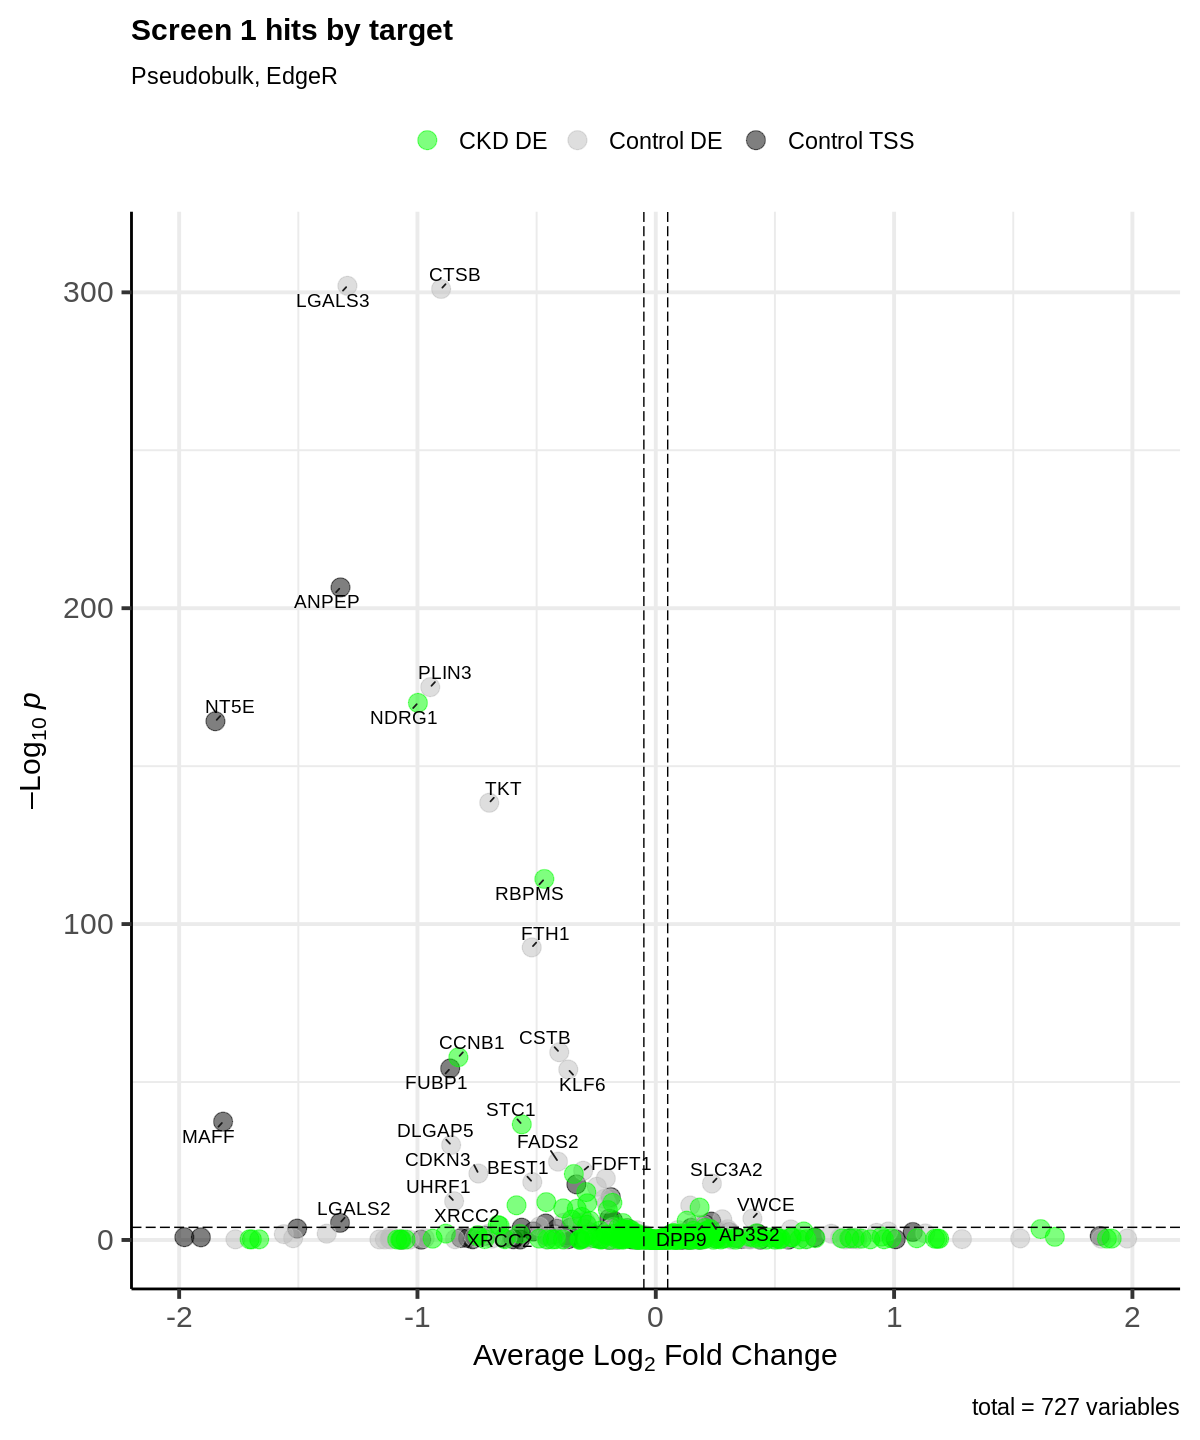

In [169]:
options(repr.plot.width = 10, repr.plot.height = 12)
EnhancedVolcano(df_neighbor_de, 
                lab = df_neighbor_de$de_gene,
                x ="logFC",
                y ="PValue",
                title = 'Screen 1 hits by target',
                subtitle = 'Pseudobulk, EdgeR', 
                colCustom = colors,
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-2, 2) +
                ylim(0, 310) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

# lab = df_neighbor_de$de_gene,
# drawConnectors = TRUE,

### Plot just the control TSS

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


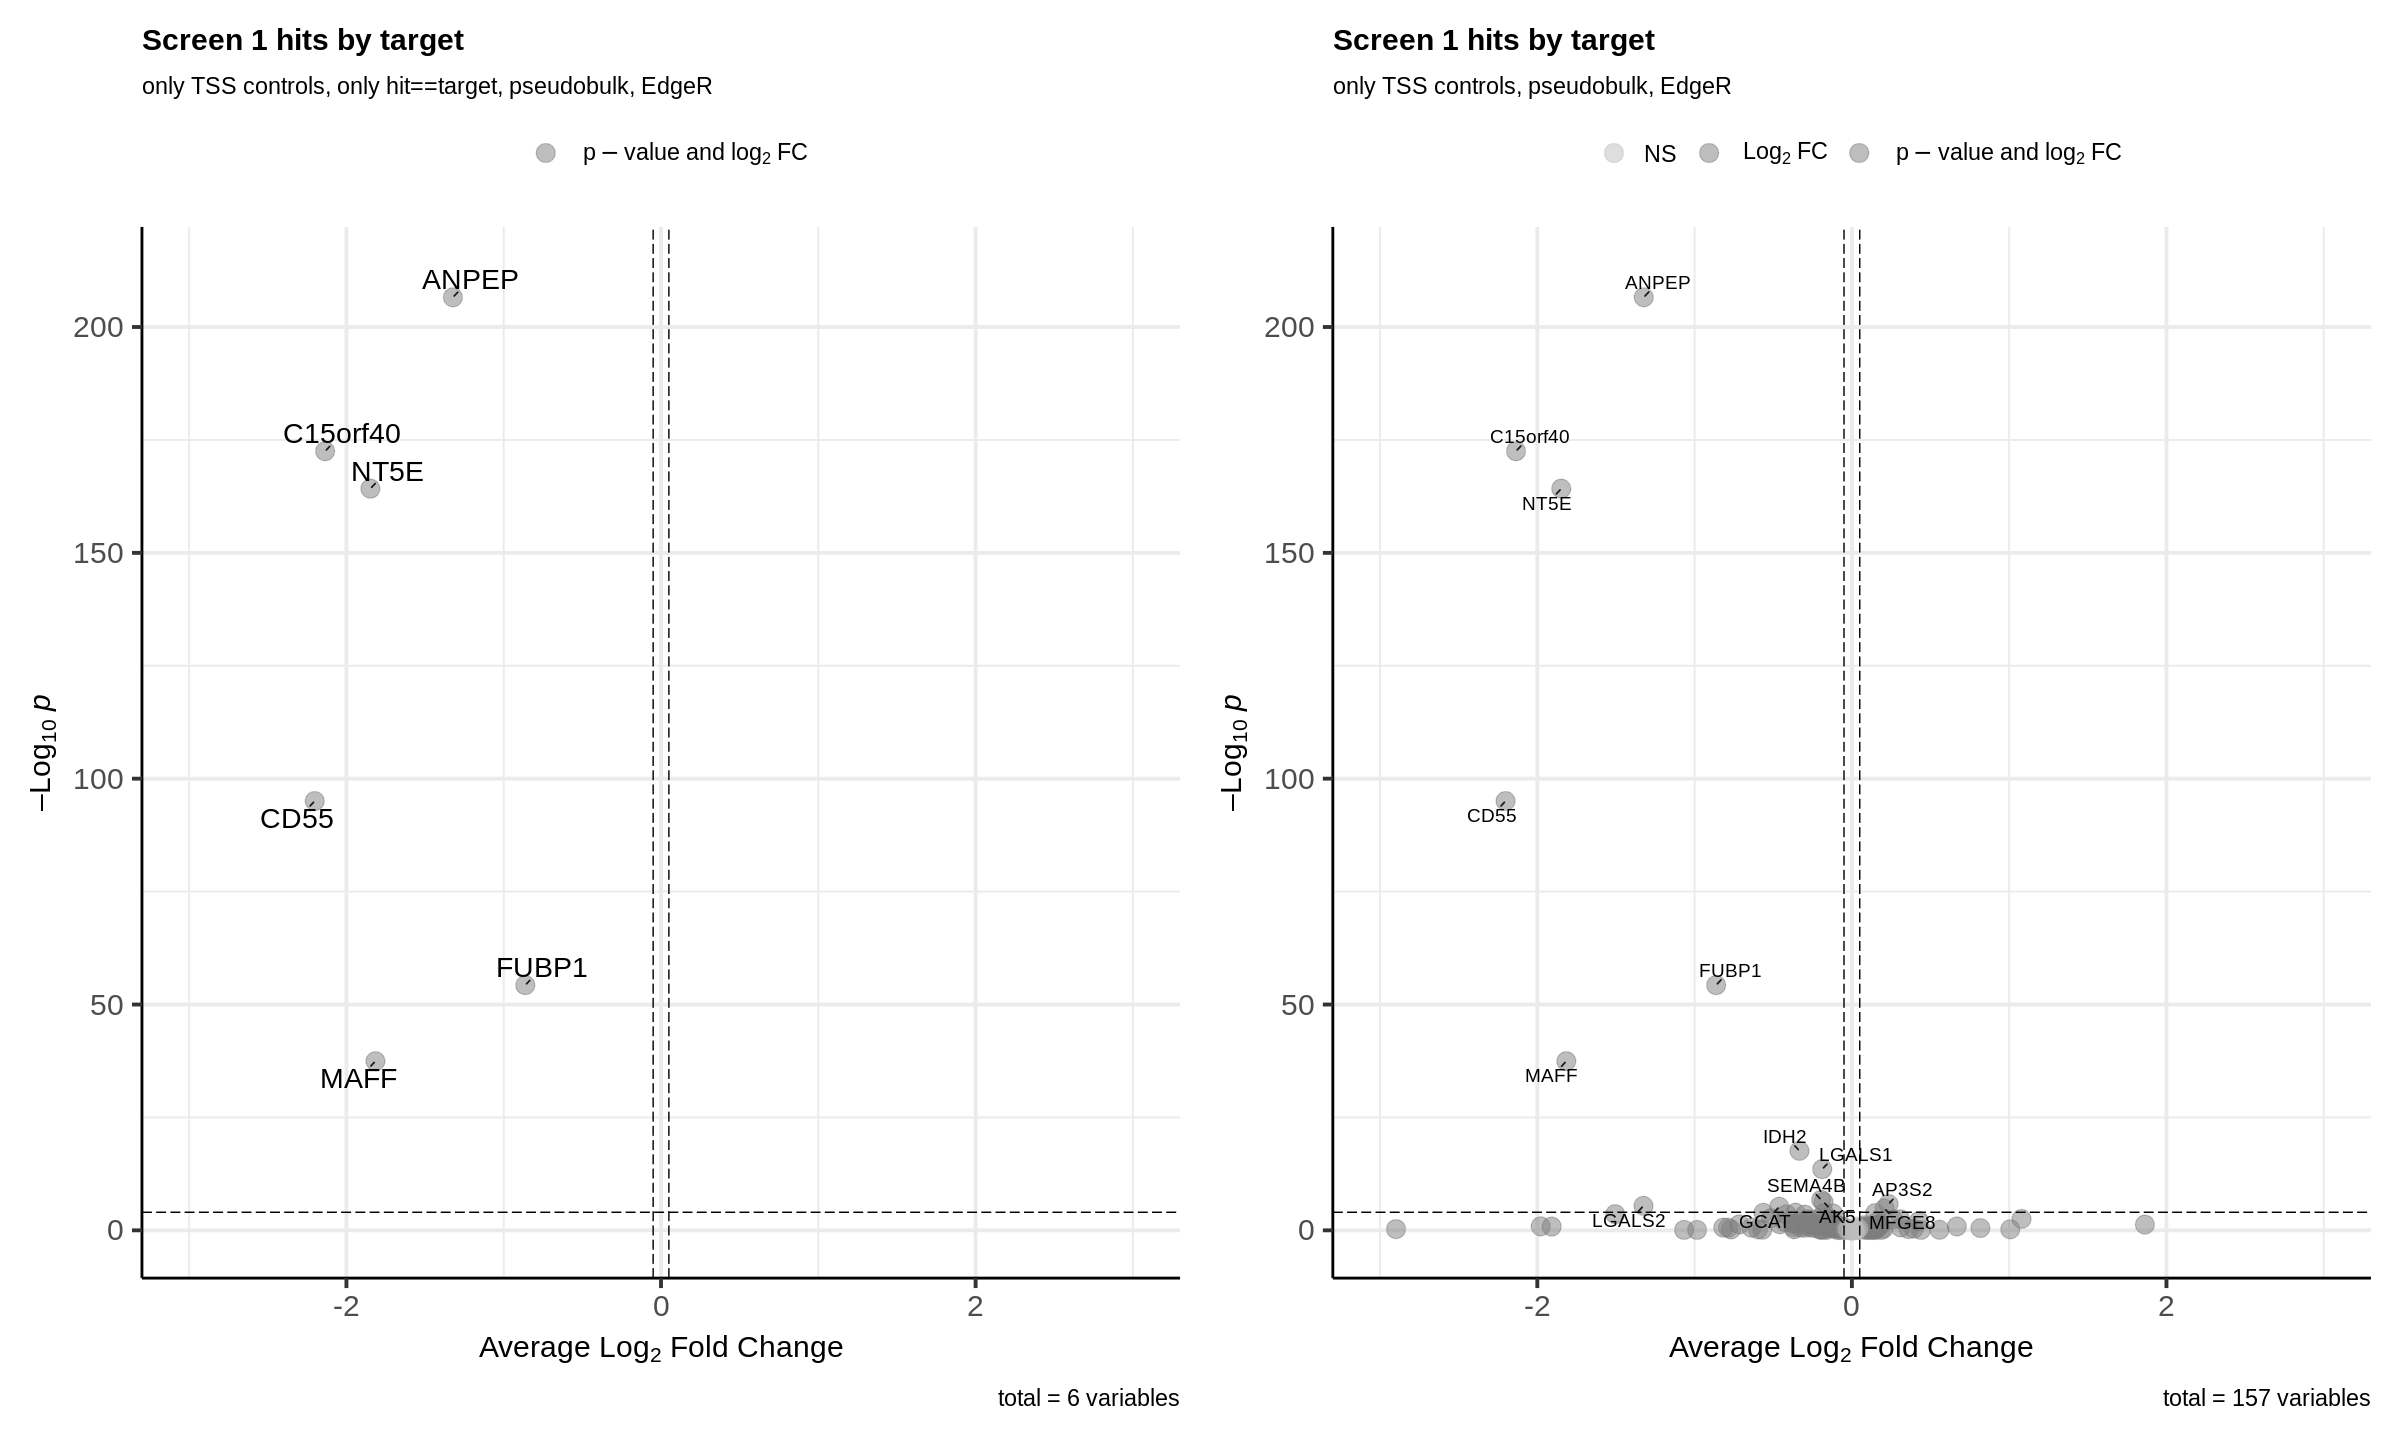

In [170]:
de_filter = (df_neighbor_de$subclass == 'tss') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y ="PValue",
                title = 'Screen 1 hits by target',
                subtitle = 'only TSS controls, only hit==target, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-3, 3) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'tss')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y ="PValue",
                title = 'Screen 1 hits by target',
                subtitle = 'only TSS controls, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-5,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 4.0
                ) +
                xlim(-3, 3) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

In [171]:
df_neighbor_de_subset

,logFC,logCPM,F,PValue,de_gene,target,subclass,label
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,-1.323,6.91,1.1e+03,2.6e-207,ANPEP,ANPEP,tss,Control TSS
2,-0.333,6.66,7.6e+01,2.5e-18,IDH2,ANPEP,tss,Control TSS
3,-0.195,6.72,2.7e+01,1.8e-07,SEMA4B,ANPEP,tss,Control TSS
4,0.233,5.38,2.3e+01,1.5e-06,AP3S2,ANPEP,tss,Control TSS
5,0.208,5.43,1.9e+01,1.5e-05,MFGE8,ANPEP,tss,Control TSS
6,-0.358,3.49,1.5e+01,1.2e-04,FANCI,ANPEP,tss,Control TSS
7,0.149,6.33,1.4e+01,1.5e-04,NGRN,ANPEP,tss,Control TSS
8,-0.120,7.72,1.4e+01,1.8e-04,CIB1,ANPEP,tss,Control TSS
9,-0.514,1.86,9.5e+00,2.1e-03,BLM,ANPEP,tss,Control TSS


### Plot just the control DE

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"ggrepel: 29 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


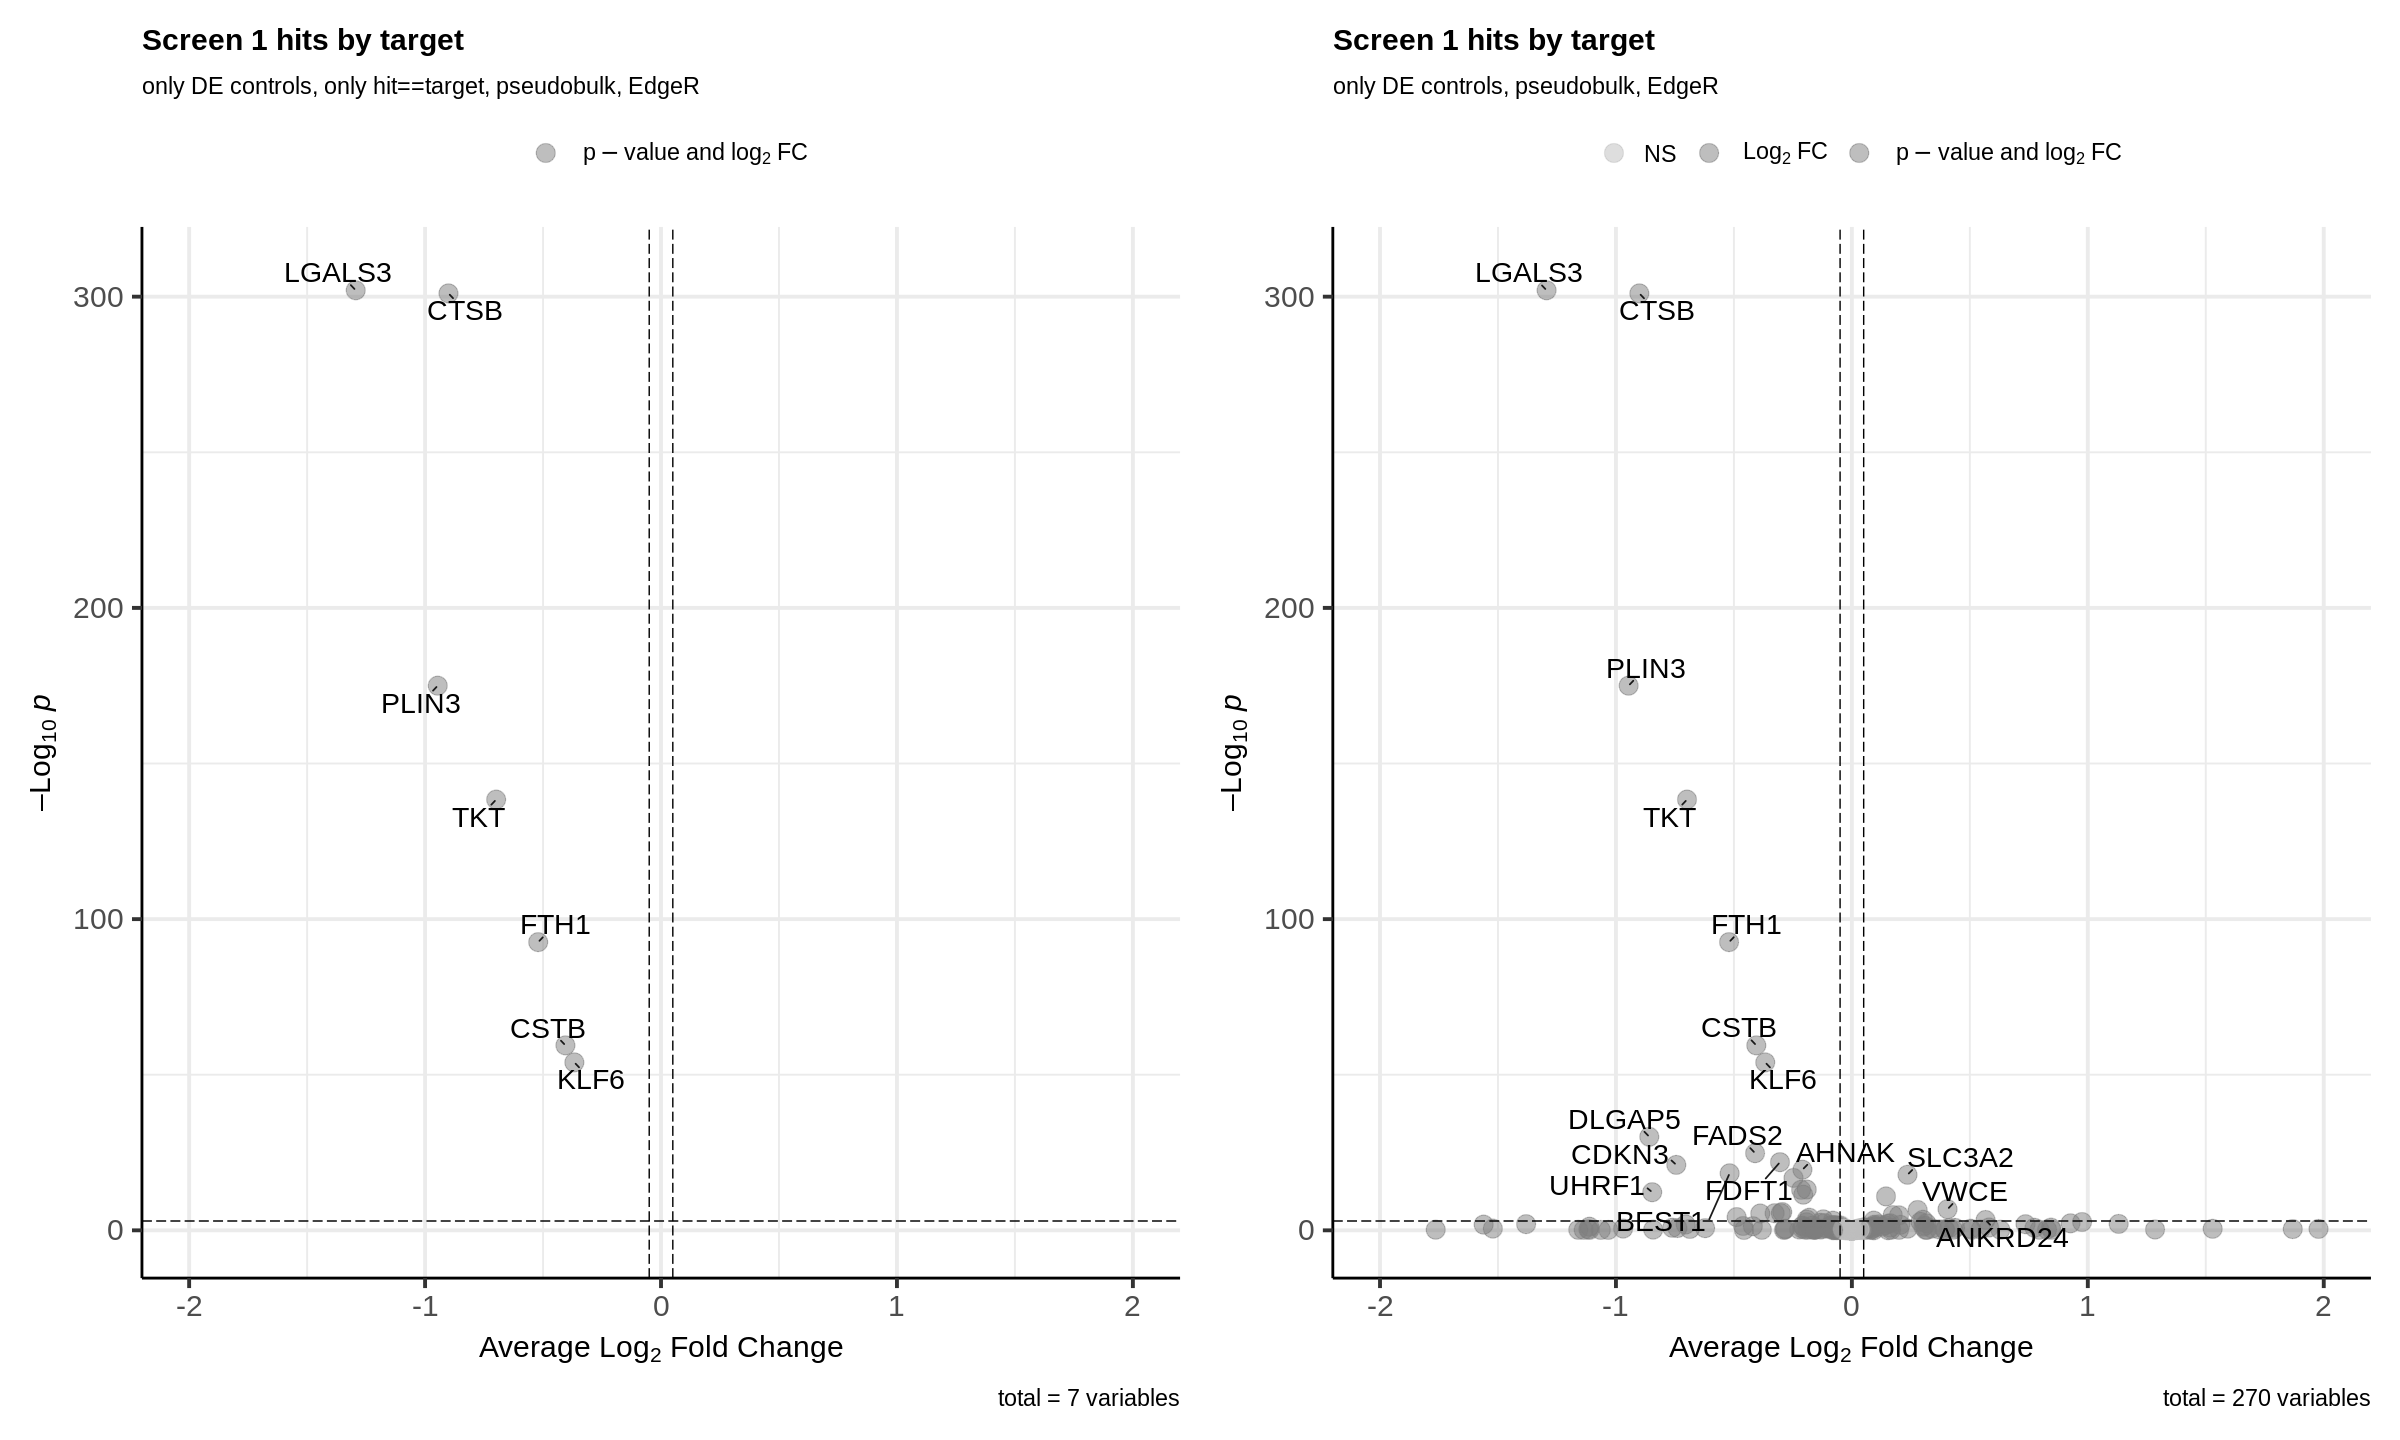

In [172]:
de_filter = (df_neighbor_de$subclass == 'de_control') & (df_neighbor_de$target == df_neighbor_de$de_gene)
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 20, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y ="PValue",
                title = 'Screen 1 hits by target',
                subtitle = 'only DE controls, only hit==target, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-2, 2) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))


de_filter = (df_neighbor_de$subclass == 'de_control')
df_neighbor_de_subset = df_neighbor_de[de_filter ,]
p2 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y ="PValue",
                title = 'Screen 1 hits by target',
                subtitle = 'only DE controls, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = 0.05,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-2, 2) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 + p2

### Plot just the CKD DE

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


Warning message:
"ggrepel: 27 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


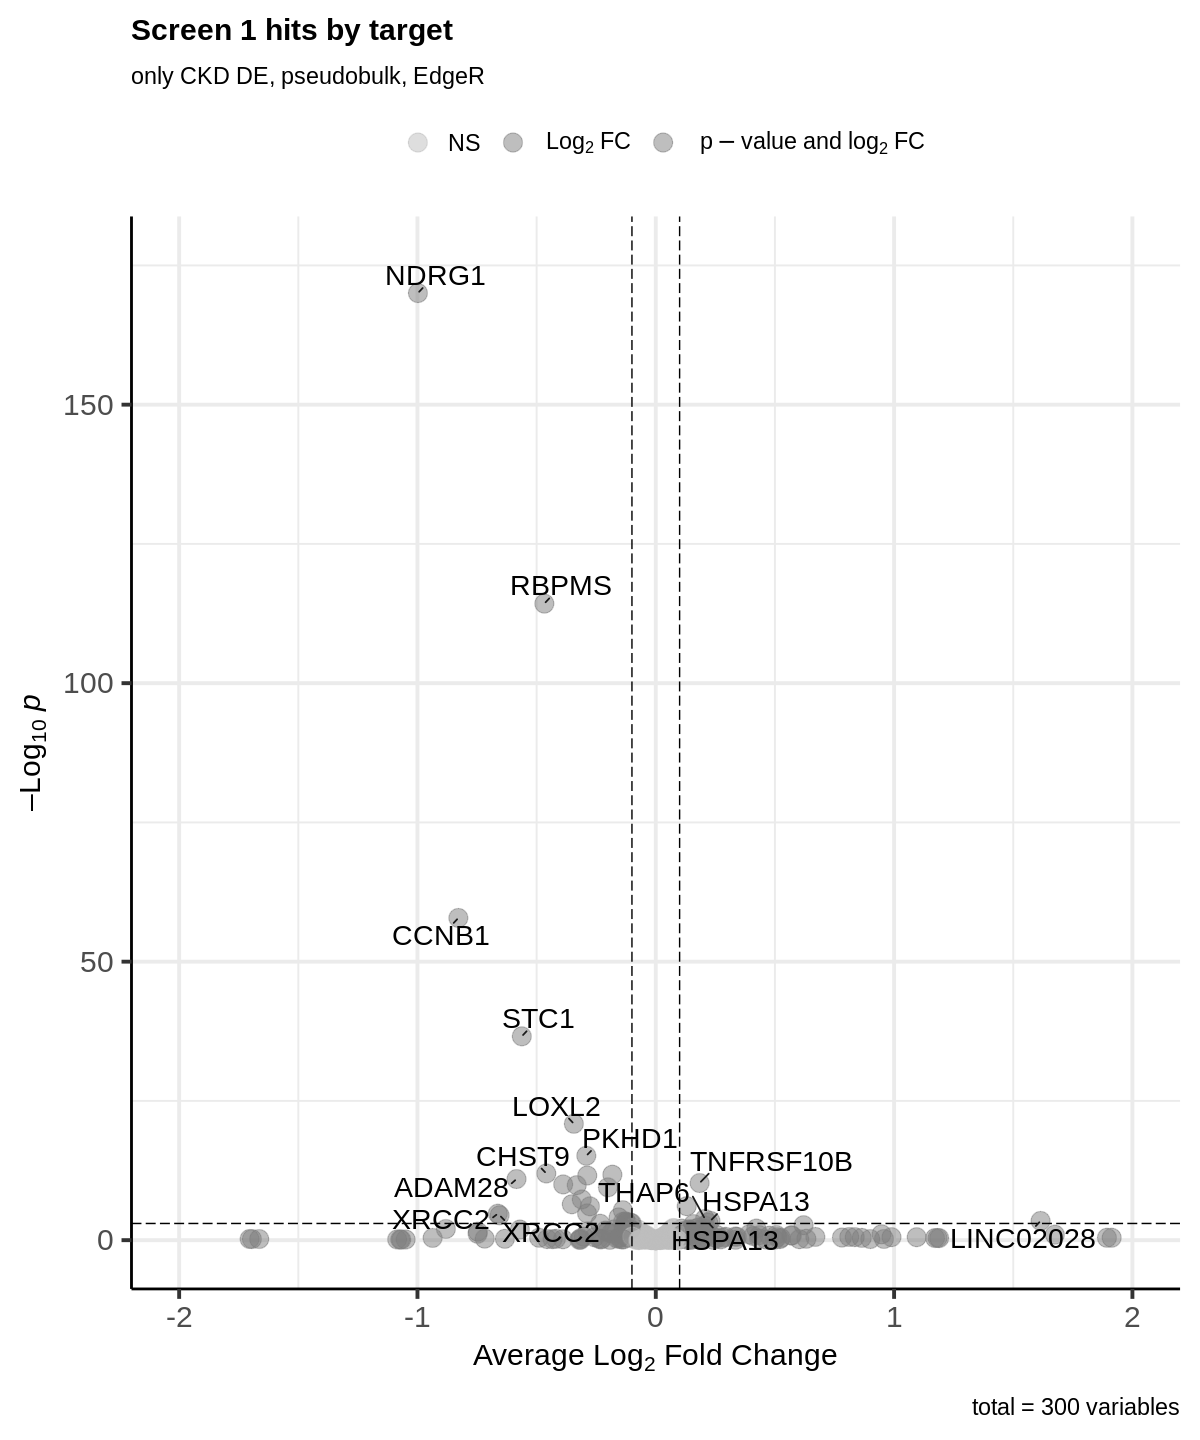

In [173]:
de_filter = (df_neighbor_de$label == 'CKD DE') 
df_neighbor_de_subset = df_neighbor_de[de_filter ,]

options(repr.plot.width = 10, repr.plot.height = 12)
p1 = EnhancedVolcano(df_neighbor_de_subset, 
                lab = df_neighbor_de_subset$de_gene,
                x ="logFC",
                y ="PValue",
                title = 'Screen 1 hits by target',
                subtitle = 'only CKD DE, pseudobulk, EdgeR', 
                col = 'gray',
                drawConnectors = TRUE,
                arrowheads = FALSE,
                pCutoff = 10e-4,
                FCcutoff = 0.1,
                pointSize = 5.0,
                labSize = 6.0
                ) +
                xlim(-2, 2) +
                xlab(expression(paste("Average ", Log[2], " Fold Change"))) +
                ylab(expression(paste("\u2013", Log[10], " ", italic(p))))

p1 

# Visualize

# Redundant

In [174]:
cluster_list = as.character(seurat_dummy$perturbation_status)
cluster_list[cluster_list == "target_negative"] = 1
cluster_list[cluster_list == "target_positive"] = 0
seurat_dummy$cluster = as.factor(cluster_list)
y = Seurat2PB(seurat_dummy, sample = "donor", cluster = 'cluster')

In [175]:
head(y$samples, 10)

,group,lib.size,norm.factors,sample,cluster
,<fct>,<dbl>,<dbl>,<chr>,<chr>
donor0_cluster0,1,1.2e+07,1,donor0,0
donor0_cluster1,1,1.6e+08,1,donor0,1
donor1_cluster0,1,1.5e+07,1,donor1,0
donor1_cluster1,1,1.7e+08,1,donor1,1
donor2_cluster0,1,2.0e+07,1,donor2,0
donor2_cluster1,1,2.1e+08,1,donor2,1
donor3_cluster0,1,1.7e+07,1,donor3,0
donor3_cluster1,1,1.6e+08,1,donor3,1


In [176]:
summary(y$samples$lib.size)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
1.18e+07 1.61e+07 8.90e+07 9.55e+07 1.66e+08 2.10e+08 

In [177]:
keep.samples <- y$samples$lib.size > 5e4
table(keep.samples)
y <- y[, keep.samples]

keep.samples
TRUE 
   8 

In [178]:
keep.genes <- filterByExpr(y, group=y$samples$cluster, min.count=10, min.total.count=20)
table(keep.genes)

keep.genes
FALSE  TRUE 
14704 21898 

In [179]:
y <- normLibSizes(y)
head(y$samples, 10)

,group,lib.size,norm.factors,sample,cluster
,<fct>,<dbl>,<dbl>,<chr>,<chr>
donor0_cluster0,1,1.2e+07,1.00,donor0,0
donor0_cluster1,1,1.6e+08,0.99,donor0,1
donor1_cluster0,1,1.5e+07,1.02,donor1,0
donor1_cluster1,1,1.7e+08,1.01,donor1,1
donor2_cluster0,1,2.0e+07,1.00,donor2,0
donor2_cluster1,1,2.1e+08,0.99,donor2,1
donor3_cluster0,1,1.7e+07,1.00,donor3,0
donor3_cluster1,1,1.6e+08,0.98,donor3,1


In [180]:
summary(y$samples$norm.factors)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.98    0.99    1.00    1.00    1.01    1.02 

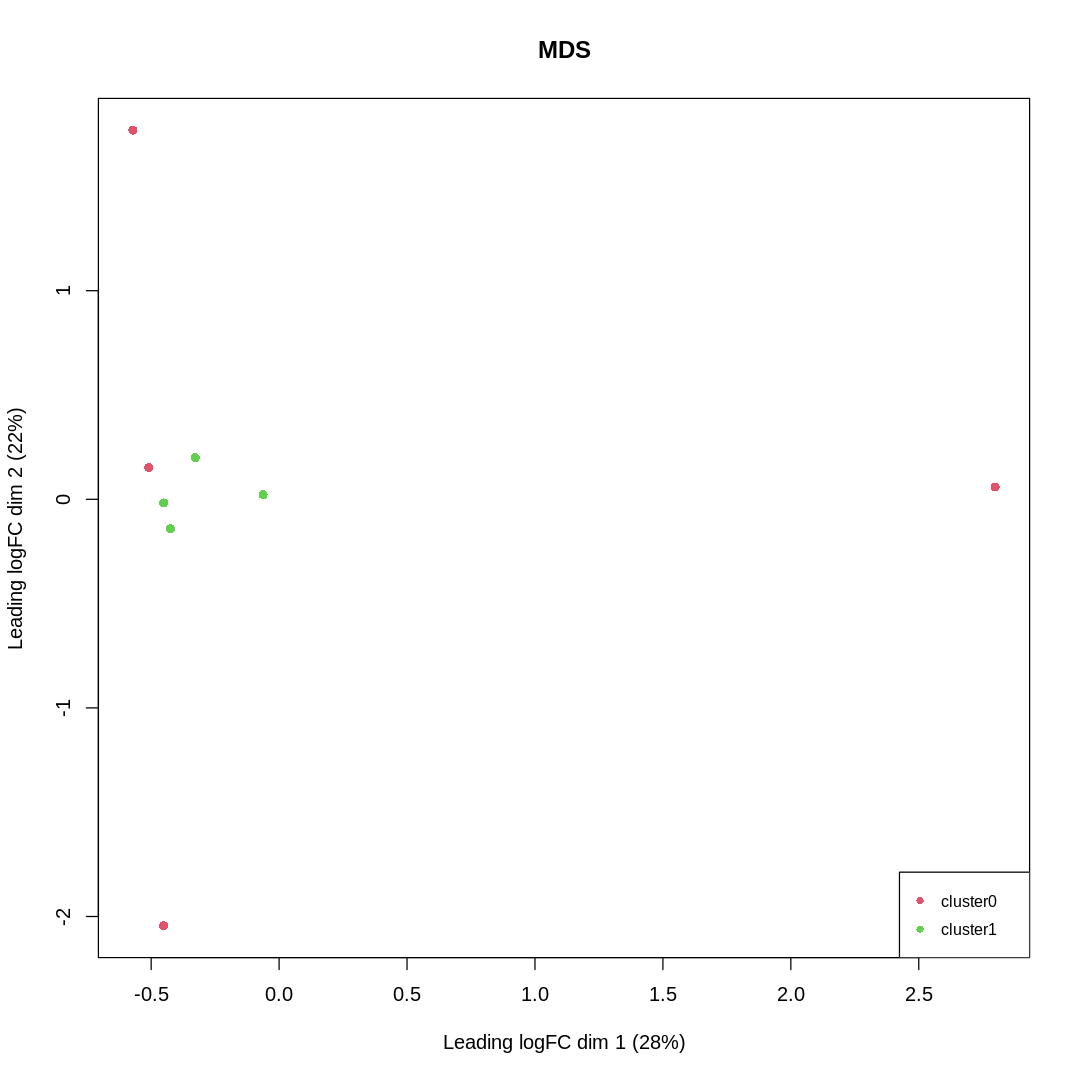

In [181]:
options(repr.plot.width=9, repr.plot.height=9)
cluster <- as.factor(y$samples$cluster)
plotMDS(y, pch=16, col=c(2:8)[cluster], main="MDS")
legend("bottomright", legend=paste0("cluster",levels(cluster)), pch=16, col=2:8, cex=0.8)

In [182]:
donor <- factor(y$samples$sample)
design <- model.matrix(~ cluster + donor)
colnames(design) <- gsub("donor", "", colnames(design))
colnames(design)[1] <- "Int"
head(design)

,Int,cluster1,1,2,3
1,1,0,0,0,0
2,1,1,0,0,0
3,1,0,1,0,0
4,1,1,1,0,0
5,1,0,0,1,0
6,1,1,0,1,0


In [183]:
donor
cluster

[1] donor0 donor0 donor1 donor1 donor2 donor2 donor3 donor3
Levels: donor0 donor1 donor2 donor3

[1] 0 1 0 1 0 1 0 1
Levels: 0 1

[1] 0.00098

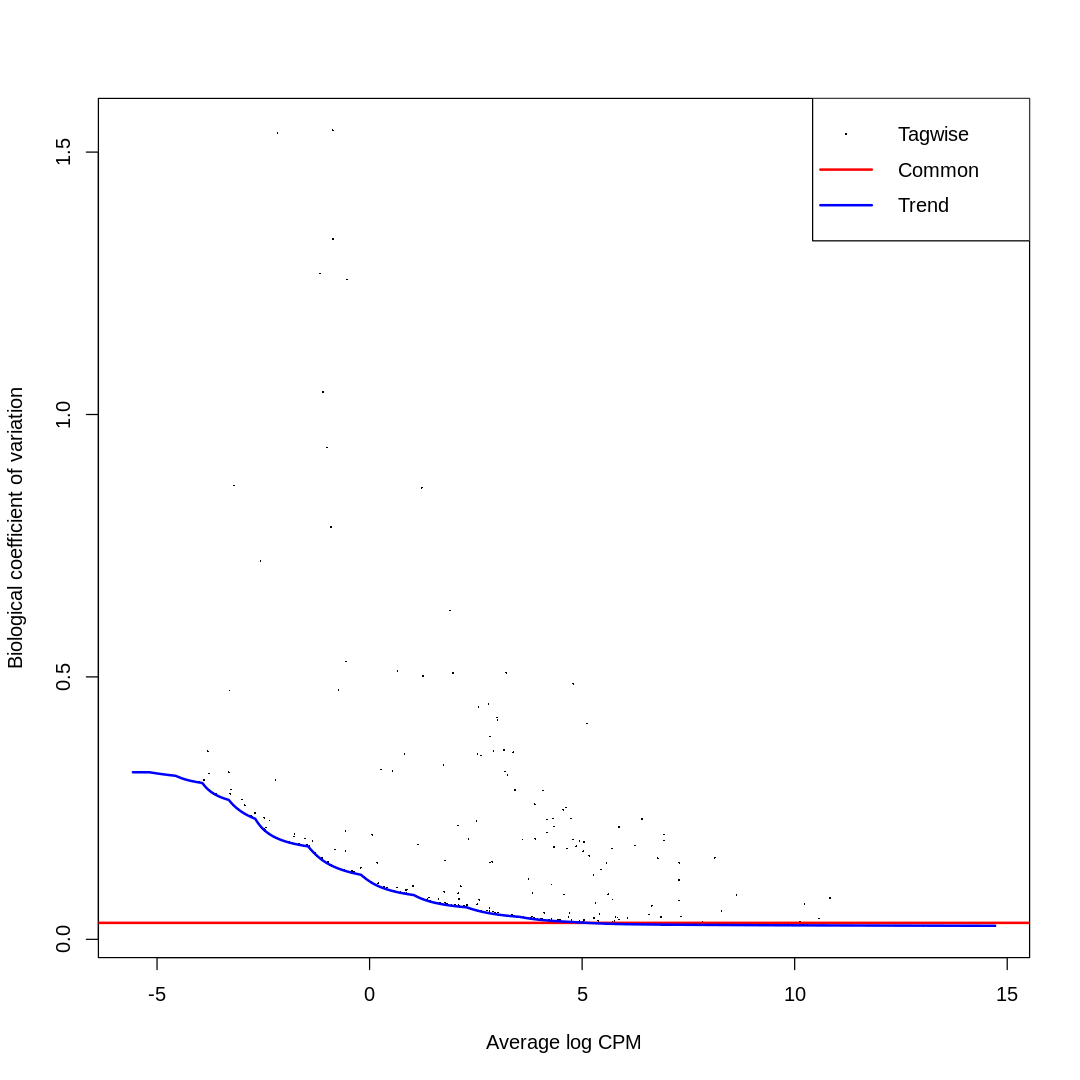

In [184]:
y <- estimateDisp(y, design, robust=TRUE)
y$common.dispersion

plotBCV(y)

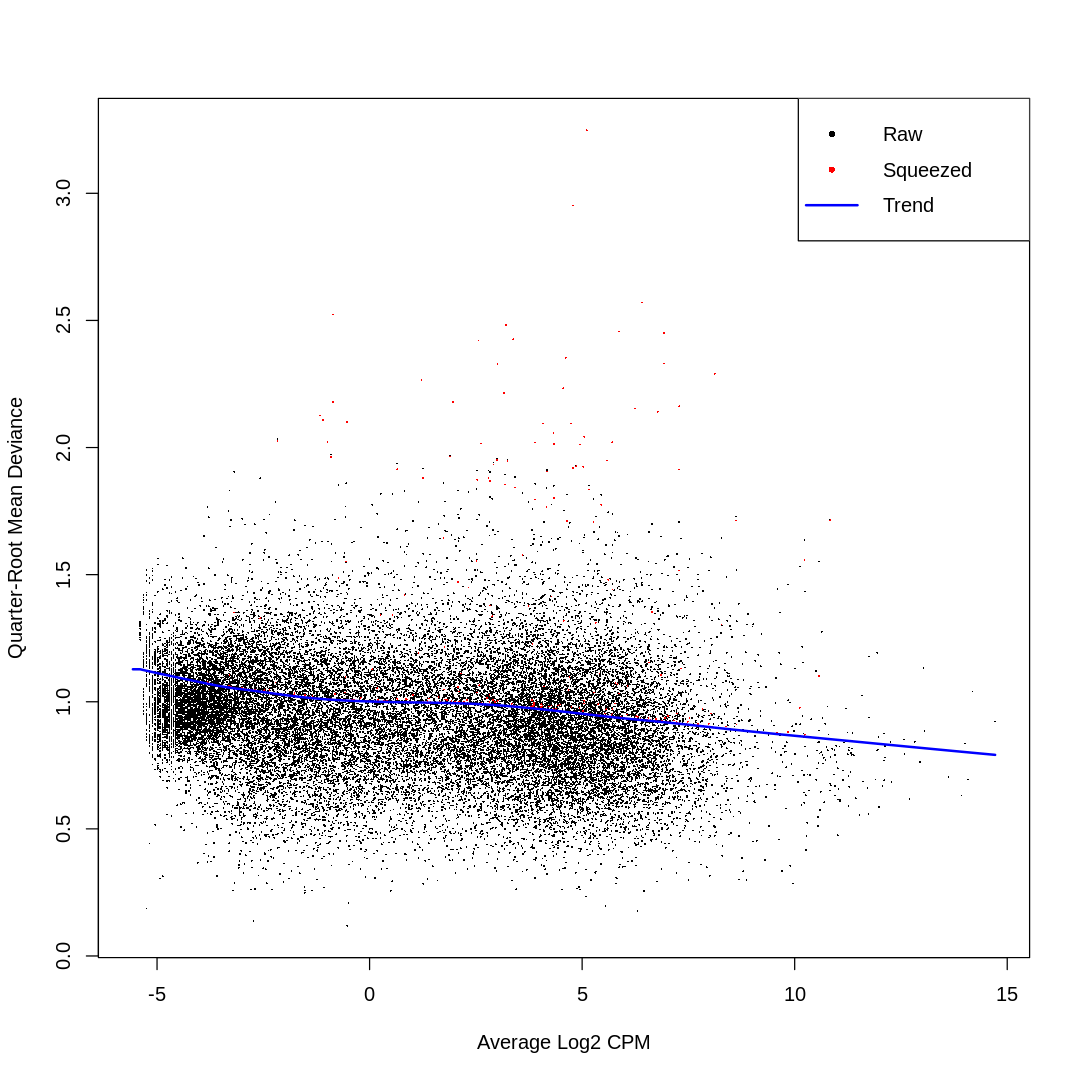

In [185]:
fit <- glmQLFit(y, design, robust=TRUE)
plotQLDisp(fit)

In [186]:
ncls <- nlevels(cluster)
contr <- rbind( matrix(1/(1-ncls), ncls, ncls), matrix(0, ncol(design)-ncls, ncls) )
diag(contr) <- 1
contr[1,] <- 0
rownames(contr) <- colnames(design)
colnames(contr) <- paste0("cluster", levels(cluster))
contr

,cluster0,cluster1
Int,0,0
cluster1,-1,1
1,0,0
2,0,0
3,0,0


In [187]:
qlf <- list()
for(i in 1:ncls) {
    qlf[[i]] <- glmQLFTest(fit, contrast=contr[,i])
    qlf[[i]]$comparison <- paste0("cluster", levels(cluster)[i], "_vs_others") 
}

In [188]:
qlf[[1]]$table[neighbors, ] %>% arrange(PValue)

,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
XRCC2,-0.6553,1.30,17.1896,3.4e-05
GALNT11,-0.1011,6.50,11.0392,8.9e-04
TMEM176A,-0.1268,4.82,7.8122,5.2e-03
RHEB,0.0738,7.21,7.4104,6.5e-03
TMEM176B,-0.1053,5.14,6.4694,1.1e-02
AGAP3,0.1421,3.93,5.9970,1.4e-02
NUB1,0.0816,5.56,5.0037,2.5e-02
AOC1,-0.2852,1.76,4.9709,2.6e-02
KMT2C,0.0483,6.99,2.9791,8.4e-02


In [189]:
dt <- lapply(lapply(qlf, decideTestsDGE), summary)
dt.all <- do.call("cbind", dt)
dt.all

,cluster0_vs_others,cluster1_vs_others
Down,2409,1234
NotSig,32959,32959
Up,1234,2409


In [190]:
top <- 20
topMarkers <- list()

for(i in 1:ncls) {
     ord <- order(qlf[[i]]$table$PValue, decreasing=FALSE)
     up <- qlf[[i]]$table$logFC > 0
    topMarkers[[i]] <- rownames(y)[ord[up][1:top]] 
}

topMarkers <- unique(unlist(topMarkers))
topMarkers

[1] "AL138828.1" "OLAH"       "SLPI"       "SMYD3"      "MMP7"      
 [6] "CDH6"       "CRIP1"      "SERPINA1"   "PSAP"       "LINC02532" 
[11] "ASPM"       "KCNMB2-AS1" "SLCO4C1"    "SPINK1"     "PTMA"      
[16] "HMGB2"      "CKB"        "TPX2"       "KRT7"       "TUBA1B"    
[21] "LINC01781"  "MT1G"       "DDIT3"      "GDF15"      "SQSTM1"    
[26] "PTTG1"      "KRT19"      "VCAM1"      "NUSAP1"     "ITPKA"     
[31] "PRC1"       "SESN2"      "VCAN"       "SLC4A4"     "ABI3BP"    
[36] "DLGAP5"     "NLGN1"      "MDM2"       "TSPAN1"     "TKT"

In [191]:
ncls

[1] 2

In [192]:
qlf[[1]]$table %>% filter(logFC < 0) %>% arrange(PValue)

,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
LINC01781,-0.53,7.2,360,3.8e-80
SLPI,-0.45,8.4,355,4.5e-79
MT1G,-0.52,7.2,348,8.5e-77
MMP7,-0.47,7.5,304,9.0e-68
CDH6,-0.36,9.7,285,7.8e-64
CRIP1,-0.57,6.1,279,1.2e-62
SERPINA1,-0.40,10.2,361,2.3e-62
LINC02532,-0.49,6.7,272,3.7e-60
PTTG1,-0.66,5.4,267,1.2e-59


In [193]:
qlf[[1]]$table['ANPEP',]

,logFC,logCPM,F,PValue
,<dbl>,<dbl>,<dbl>,<dbl>
ANPEP,-0.22,7.2,66,4.8e-16


## Check using Seurat FindMarkers

In [194]:
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.1

markers <- FindMarkers(
    object = seurat_dummy,
    features = neighbors,
    slot = "data",
    ident.1 = 'target_positive',
    ident.2 = 'target_negative',
    test.use = test_use,
    logfc.threshold = logfc_threshold,
    latent.vars = c("library", "donor"),
    only.pos = FALSE, 
    verbose = FALSE
)


Warning message in FindMarkers.default(object = data.use, slot = data.slot, counts = counts, :
"No features pass logfc.threshold threshold; returning empty data.frame"


In [195]:
markers

avg_log2FC,pct.1,pct.2
<dbl>,<dbl>,<dbl>


In [196]:
head(counts@.Data)

,target_positive,target_negative
MIR1302-2HG,1,3
FAM138A,0,0
OR4F5,1,5
AL627309.1,32,262
AL627309.3,4,11
AL627309.2,0,0
AL627309.5,34,356
AL627309.4,2,4
AP006222.2,0,2
AL732372.1,1,3


In [197]:
y

,donor0_cluster0,donor0_cluster1,donor1_cluster0,donor1_cluster1,donor2_cluster0,donor2_cluster1,donor3_cluster0,donor3_cluster1
MIR1302-2HG,1,0,0,0,0,0,0,3
FAM138A,0,0,0,0,0,0,0,0
OR4F5,0,1,0,1,0,0,0,4
AL627309.1,6,61,6,65,10,74,11,61
AL627309.3,0,4,1,3,0,6,0,1
AL627309.2,0,0,0,0,0,0,0,0
AL627309.5,5,65,8,100,13,118,8,73
AL627309.4,0,1,1,2,0,2,0,0
AP006222.2,0,0,0,0,0,1,0,1
AL732372.1,0,1,0,2,0,1,0,0


In [198]:
df_targets = unique(filter(df_guide, subclass=='ckd_de')[,c('alias','gene','subclass', 'label')])
df_targets = unique(filter(df_guide, class=='targeting')[,c('alias','gene','subclass', 'label')])
df_neighbor_de = NULL
test_use = "LR" #"MAST"  #"wilcox" "LR"
guides_to_skip = c()  #c("DE6", "DE15")  
logfc_threshold = 0.01

for(i in 1:nrow(df_targets)) {
    target          = df_targets[i,'alias']
    target_subclass = df_targets[i, 'subclass']
    label           = df_targets[i, 'label']
    snp_id_or_gene_name = df_targets[i,'gene']
    
    if(!str_detect(target, regex("^DE\\d+$"))) {
        ckd_de = 
        neighbors = neighbors_list[[target]]
    } else {
        neighbors = neighbors_list[[snp_id_or_gene_name]]
    }

    if((target %in% guides_to_skip) | length(neighbors) == 0 ){
        cat(red("Skipping", target, snp_id_or_gene_name, length(neighbors), "\n"))
        next
    }
    guides_4_target = get_guides_by_subclass(df_guide, 'alias', target)
    cat(blue(target, target,":"), paste(guides_4_target, collapse=","),"\n")
    seurat_dummy <- mark_target_pos_neg(seurat_rna, perturbed_cells_by_guide, guides_4_target, print_counts = T)
    seurat_dummy$perturbation_status = Idents(seurat_dummy)
    seurat_dummy$donor = paste0("donor", seurat_dummy$donor)
    print(table(filter(seurat_dummy@meta.data, perturbation_status == 'target_positive')$donor) )

    # Use each donor as a replicate
    cluster_list = as.character(seurat_dummy$perturbation_status)
    cluster_list[cluster_list == "target_negative"] = 1
    cluster_list[cluster_list == "target_positive"] = 0
    seurat_dummy$cluster = as.factor(cluster_list)
    y = Seurat2PB(seurat_dummy, sample = "donor", cluster = 'cluster')
    break
}

ANPEP ANPEP : CD13-1a,CD13-1b 
CD13-1a   867 
CD13-1b   1161 
Guide+ = 1161 ; Guide- = 25981 

donor0 donor1 donor2 donor3 
   270    233    385    273 


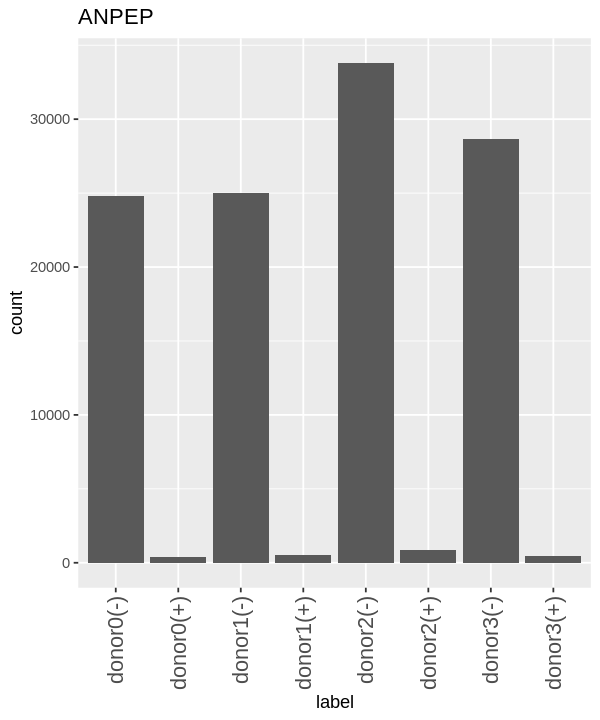

In [199]:
options(repr.plot.width=5, repr.plot.height=6)
df_dummy = as.data.frame(y$count[target,])
colnames(df_dummy) <- target
df_dummy$label = rownames(df_dummy)
rownames(df_dummy) <- NULL
df_dummy$label = str_replace(df_dummy$label, "_cluster0", "(+)")
df_dummy$label = str_replace(df_dummy$label, "_cluster1", "(-)")
#df_dummy = t(df_dummy)
#labels = colnames(df_dummy)

ggplot(df_dummy, aes(label)) +
     geom_bar(aes(weight=get(target))) +
     theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 13)) +
     labs(title=target)

In [200]:
head(df_cell_counts)

,count,target,label
,<dbl>,<chr>,<chr>
donor0_cluster0,388,ANPEP,donor0(+)
donor0_cluster1,24813,ANPEP,donor0(-)
donor1_cluster0,533,ANPEP,donor1(+)
donor1_cluster1,25027,ANPEP,donor1(-)
donor2_cluster0,835,ANPEP,donor2(+)
donor2_cluster1,33783,ANPEP,donor2(-)


In [201]:
df_cell_counts

,count,target,label
,<dbl>,<chr>,<chr>
donor0_cluster0,388,ANPEP,donor0(+)
donor0_cluster1,24813,ANPEP,donor0(-)
donor1_cluster0,533,ANPEP,donor1(+)
donor1_cluster1,25027,ANPEP,donor1(-)
donor2_cluster0,835,ANPEP,donor2(+)
donor2_cluster1,33783,ANPEP,donor2(-)
donor3_cluster0,466,ANPEP,donor3(+)
donor3_cluster1,28657,ANPEP,donor3(-)
donor0_cluster01,30,CD55,donor0(+)


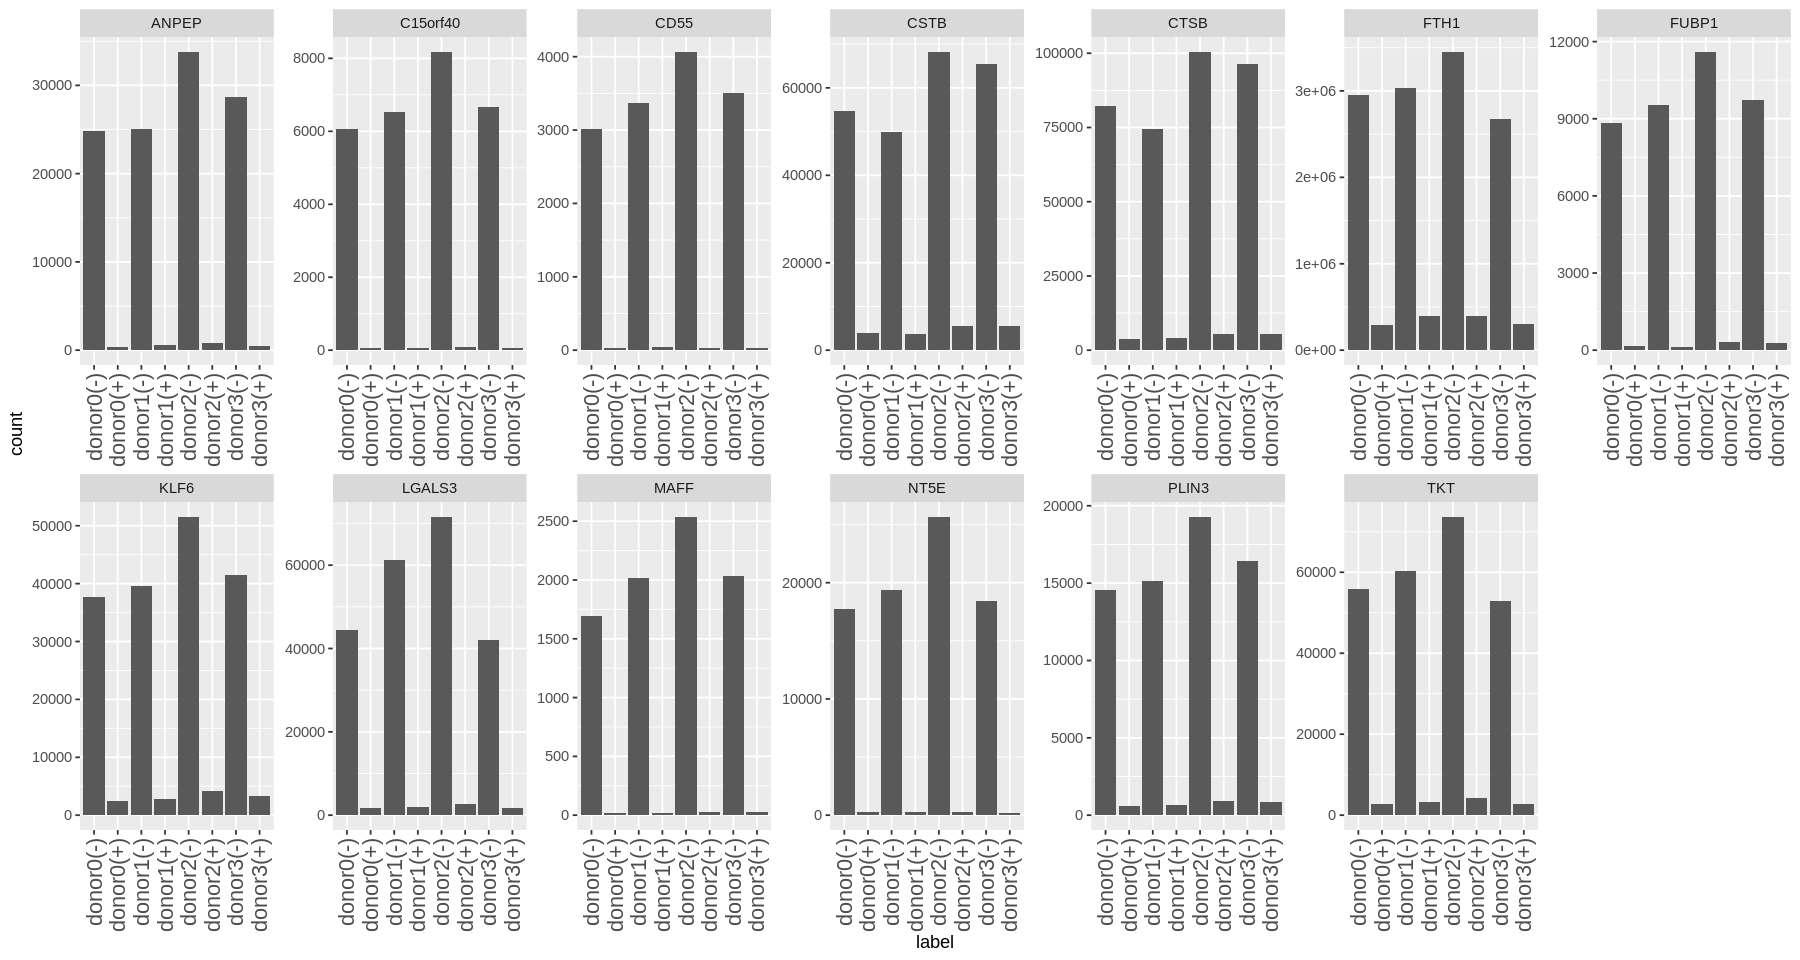

In [202]:

options(repr.plot.width=15, repr.plot.height=8)
ggplot(df_cell_counts, aes(label)) +
    geom_bar(aes(weight=count)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1, size = 13)) +
    facet_wrap(~ target, scales="free", ncol = 7)
     

In [203]:
y$counts[target,]

donor0_cluster0 donor0_cluster1 donor1_cluster0 donor1_cluster1 donor2_cluster0 
            388           24813             533           25027             835 
donor2_cluster1 donor3_cluster0 donor3_cluster1 
          33783             466           28657

In [204]:
head(df_cell_counts)

,count,target,label
,<dbl>,<chr>,<chr>
donor0_cluster0,388,ANPEP,donor0(+)
donor0_cluster1,24813,ANPEP,donor0(-)
donor1_cluster0,533,ANPEP,donor1(+)
donor1_cluster1,25027,ANPEP,donor1(-)
donor2_cluster0,835,ANPEP,donor2(+)
donor2_cluster1,33783,ANPEP,donor2(-)


In [205]:
log(388/24813, 10)

[1] -1.8

In [206]:
head(df_neighbor_de)

NULL

In [210]:
donor
cluster

[1] donor0 donor0 donor1 donor1 donor2 donor2 donor3 donor3
Levels: donor0 donor1 donor2 donor3

[1] 0 1 0 1 0 1 0 1
Levels: 0 1

In [209]:
design

,Int,cluster1,1,2,3
1,1,0,0,0,0
2,1,1,0,0,0
3,1,0,1,0,0
4,1,1,1,0,0
5,1,0,0,1,0
6,1,1,0,1,0
7,1,0,0,0,1
8,1,1,0,0,1


In [215]:
table(Idents(seurat_dummy))


target_positive target_negative 
           1161           25981 

In [224]:
as.data.frame(table(seurat_dummy@meta.data[,c('perturbation_status','donor')]))

perturbation_status,donor,Freq
<fct>,<fct>,<int>
target_positive,donor0,270
target_negative,donor0,6744
target_positive,donor1,233
target_negative,donor1,5579
target_positive,donor2,385
target_negative,donor2,7687
target_positive,donor3,273
target_negative,donor3,5971


In [231]:
head(df_cell_counts)

,count,target,label,group,lib.size,norm.factors,sample,cluster
,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>
1,388,ANPEP,donor0_cluster0,1,6909188,1,donor0,0
2,24813,ANPEP,donor0_cluster1,1,6909188,1,donor0,0
3,533,ANPEP,donor1_cluster0,1,6909188,1,donor0,0
4,25027,ANPEP,donor1_cluster1,1,6909188,1,donor0,0
5,835,ANPEP,donor2_cluster0,1,6909188,1,donor0,0
6,33783,ANPEP,donor2_cluster1,1,6909188,1,donor0,0


In [228]:
y$samples

,group,lib.size,norm.factors,sample,cluster
,<fct>,<dbl>,<dbl>,<chr>,<chr>
donor0_cluster0,1,6.9e+06,1,donor0,0
donor0_cluster1,1,1.6e+08,1,donor0,1
donor1_cluster0,1,7.9e+06,1,donor1,0
donor1_cluster1,1,1.7e+08,1,donor1,1
donor2_cluster0,1,1.2e+07,1,donor2,0
donor2_cluster1,1,2.2e+08,1,donor2,1
donor3_cluster0,1,7.9e+06,1,donor3,0
donor3_cluster1,1,1.7e+08,1,donor3,1


In [234]:
df_dummy = as.data.frame(y$counts[target,])
colnames(df_dummy) = "count"
df_dummy$target <- target
df_dummy$label = rownames(df_dummy)
df_samples = y$samples


In [235]:
df_dummy

,count,target,label
,<dbl>,<chr>,<chr>
donor0_cluster0,388,ANPEP,donor0_cluster0
donor0_cluster1,24813,ANPEP,donor0_cluster1
donor1_cluster0,533,ANPEP,donor1_cluster0
donor1_cluster1,25027,ANPEP,donor1_cluster1
donor2_cluster0,835,ANPEP,donor2_cluster0
donor2_cluster1,33783,ANPEP,donor2_cluster1
donor3_cluster0,466,ANPEP,donor3_cluster0
donor3_cluster1,28657,ANPEP,donor3_cluster1


In [236]:
df_samples

,group,lib.size,norm.factors,sample,cluster
,<fct>,<dbl>,<dbl>,<chr>,<chr>
donor0_cluster0,1,6.9e+06,1.02,donor0,0
donor0_cluster1,1,1.6e+08,0.99,donor0,1
donor1_cluster0,1,7.9e+06,1.02,donor1,0
donor1_cluster1,1,1.7e+08,1.00,donor1,1
donor2_cluster0,1,1.2e+07,1.00,donor2,0
donor2_cluster1,1,2.2e+08,0.98,donor2,1
donor3_cluster0,1,7.9e+06,1.01,donor3,0
donor3_cluster1,1,1.7e+08,0.98,donor3,1


In [238]:
 merge(df_dummy, df_samples, by = 0)

Row.names,count,target,label,group,lib.size,norm.factors,sample,cluster
<I<chr>>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>
donor0_cluster0,388,ANPEP,donor0_cluster0,1,6.9e+06,1.02,donor0,0
donor0_cluster1,24813,ANPEP,donor0_cluster1,1,1.6e+08,0.99,donor0,1
donor1_cluster0,533,ANPEP,donor1_cluster0,1,7.9e+06,1.02,donor1,0
donor1_cluster1,25027,ANPEP,donor1_cluster1,1,1.7e+08,1.00,donor1,1
donor2_cluster0,835,ANPEP,donor2_cluster0,1,1.2e+07,1.00,donor2,0
donor2_cluster1,33783,ANPEP,donor2_cluster1,1,2.2e+08,0.98,donor2,1
donor3_cluster0,466,ANPEP,donor3_cluster0,1,7.9e+06,1.01,donor3,0
donor3_cluster1,28657,ANPEP,donor3_cluster1,1,1.7e+08,0.98,donor3,1


In [242]:
head(df_cell_counts)

,Row.names,count,target,label,group,lib.size,norm.factors,sample,cluster
,<I<chr>>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>
1,donor0_cluster0,388,ANPEP,donor0_cluster0,1,6.9e+06,1,donor0,0
2,donor0_cluster1,24813,ANPEP,donor0_cluster1,1,1.6e+08,1,donor0,1
3,donor1_cluster0,533,ANPEP,donor1_cluster0,1,7.9e+06,1,donor1,0
4,donor1_cluster1,25027,ANPEP,donor1_cluster1,1,1.7e+08,1,donor1,1
5,donor2_cluster0,835,ANPEP,donor2_cluster0,1,1.2e+07,1,donor2,0
6,donor2_cluster1,33783,ANPEP,donor2_cluster1,1,2.2e+08,1,donor2,1


In [245]:
df_cell_counts$norm_counts = max(df_cell_counts$lib.size) * df_cell_counts$count/df_cell_counts$lib.size

In [249]:
head(df_cell_counts)

,Row.names,count,target,label,group,lib.size,norm.factors,sample,cluster,norm_counts,norm_count
,<I<chr>>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
1,donor0_cluster0,388,ANPEP,donor0(+),1,6.9e+06,1,donor0,0,12474,56157
2,donor0_cluster1,24813,ANPEP,donor0(-),1,1.6e+08,1,donor0,1,33842,152352
3,donor1_cluster0,533,ANPEP,donor1(+),1,7.9e+06,1,donor1,0,15001,67532
4,donor1_cluster1,25027,ANPEP,donor1(-),1,1.7e+08,1,donor1,1,31867,143461
5,donor2_cluster0,835,ANPEP,donor2(+),1,1.2e+07,1,donor2,0,15111,68029
6,donor2_cluster1,33783,ANPEP,donor2(-),1,2.2e+08,1,donor2,1,34475,155204


In [252]:
design

,Int,cluster1,1,2,3
1,1,0,0,0,0
2,1,1,0,0,0
3,1,0,1,0,0
4,1,1,1,0,0
5,1,0,0,1,0
6,1,1,0,1,0
7,1,0,0,0,1
8,1,1,0,0,1
